This notebook will collect waveform data and format them into a seisbench compatible hdf5 format in order to disseminate the data sets.


by Marine Denolle (mdenolle@uw.edu)

References:
-  https://github.com/niyiyu/PNW-ML/blob/main/scripts/mpi_extract_comcat_acceleration.py



In [2]:
import os
import logging
from obspy.clients.fdsn import Client
import numpy as np
import obspy
from obspy import Stream
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import pandas as pd
import h5py
from tqdm import tqdm
from itertools import islice
import random
from pnwstore.mseed import WaveformClient

# from pnwstore.mseed import WaveformClient

In [3]:

# Define clients
client_iris = Client('IRIS')
# client_waveform = WaveformClient()
client_ncedc = Client('NCEDC')
client_waveform = WaveformClient()



## Load the data frame of picks

In [4]:
assoc_df = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/arrival_assoc_origin_2010_2015_reloc_cog_ver3.csv', index_col=0)
assoc_df.head()

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,lon,depth,otime,nass,p_picks,s_picks,rms,nsphz,gap,algorithm
0,UW.PCMD,1.262305e+09,0,P,0.68,0,P,0.049,46.888962,-122.301483,...,-122.16895,56.111,1.262305e+09,7,2,5,1.081,5.0,235.831208,genie
1,UW.RVW,1.262305e+09,1,P,0.68,0,P,1.264,46.149750,-122.742996,...,-122.16895,56.111,1.262305e+09,7,2,5,1.081,5.0,235.831208,genie
2,UW.PCMD,1.262305e+09,2,S,0.68,0,S,-0.243,46.888962,-122.301483,...,-122.16895,56.111,1.262305e+09,7,2,5,1.081,5.0,235.831208,genie
3,UW.GNW,1.262305e+09,3,S,0.68,0,S,2.402,47.564130,-122.824980,...,-122.16895,56.111,1.262305e+09,7,2,5,1.081,5.0,235.831208,genie
4,PB.B013,1.262305e+09,4,S,0.68,0,S,-0.651,47.813000,-122.910797,...,-122.16895,56.111,1.262305e+09,7,2,5,1.081,5.0,235.831208,genie


## Display basic information about the dataset


In [69]:

# Display basic information about the dataset
print(f"Number of records: {len(assoc_df)}")
print("First few rows:")
print(assoc_df.head())
print("Columns:", assoc_df.columns.tolist())

# Assuming the epoch time column is named 'time' - adjust if needed
time_column = 'time'  # Change this if your column has a different name
if time_column in assoc_df.columns:
    # Convert epoch time to datetime
    assoc_df['datetime'] = pd.to_datetime(assoc_df[time_column], unit='s')
    
    # Create a function to convert to UTCDateTime when needed
    def to_utc_datetime(dt):
        return obspy.UTCDateTime(dt)
    
    # Example conversion
    print("\nExample time conversion:")
    example = assoc_df.iloc[0]
    print(f"Epoch: {example[time_column]}")
    print(f"Datetime: {example['datetime']}")
    print(f"UTCDateTime: {to_utc_datetime(example['datetime'])}")

# # Extract unique station information
station_col = 'sta'  # Change if needed
# network_col = 'network'  # Change if needed

if station_col in assoc_df.columns:
    station_list = assoc_df[[station_col]].drop_duplicates().reset_index(drop=True)
    print(f"\nFound {len(station_list)} unique stations:")
    print(station_list.head(10))

Number of records: 1004335
First few rows:
   arid  orid      sta phase  prob  timeres  slatitude  slongitude  \
0     0     0  UW.PCMD     P  0.68    0.049  46.888962 -122.301483   
1     1     0   UW.RVW     P  0.68    1.264  46.149750 -122.742996   
2     2     0  UW.PCMD     S  0.68   -0.243  46.888962 -122.301483   
3     3     0   UW.GNW     S  0.68    2.402  47.564130 -122.824980   
4     4     0  PB.B013     S  0.68   -0.651  47.813000 -122.910797   

   selevation       delta        esaz        seaz          time iphase  \
0       239.0   38.726602  195.021971   15.021971  1.262305e+09      P   
1       504.0  127.374667  199.958459   19.958459  1.262305e+09      P   
2       239.0   38.726602  195.021971   15.021971  1.262305e+09      S   
3       220.0   62.222486  307.013042  127.013042  1.262305e+09      S   
4        75.3   85.968984  319.190764  139.190764  1.262305e+09      S   

                       datetime  
0 2010-01-01 00:15:27.180000000  
1 2010-01-01 00:15:37.8

In [ ]:
# # === CONFIGURATION ===
# client = Client("IRIS")
# network = "UW"
# station = "LON"
# location = "*"
# channel = "BH?"  # 3-component broadband
# starttime = obspy.UTCDateTime("2021-07-04T07:15:00")
# endtime = obspy.UTCDateTime("2021-07-04T07:20:00")

# sta = client_iris.get_stations(network=network, station=station,location="*",channel="*", \
#                                    starttime=starttime , endtime=endtime)
# print(sta)

Inventory created at 2025-06-17T17:13:18.687200Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2021-07-04...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			UW
		Stations (1):
			UW.LON (Longmire, WA, USA)
		Channels (0):



In [ ]:
for (event_id, network, station), group in df.groupby(['event_id', 'network', 'station']):
    # Your processing code here

## Make the hdf5 file and metadata 


In [ ]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_test.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_test.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test.csv"

# Extract network and station from sta column
df = assoc_df.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)

# Set constants
sampling_rate = 100  # Hz
pre_arrival_time = 50  # time before the first arrival in seconds
window_length = 150  # time window length in seconds

# Create a unique event ID for each unique time
# This assumes different events have different timestamps
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

# Create 10 buckets the hdf5 file
waveform_buckets_HH_BH = {str(i): [] for i in range(11)}  # 0 to 10
waveform_buckets_EH = {str(i): [] for i in range(11)}  # 0 to 10

# Group by event_id, network and station to combine P and S arrivals
rows_HH_BH = []
rows_EH = []

group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 40):
    # Find P and S arrivals
    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")
        
    
    # Calculate trace start time (50 seconds before the first arrival)
    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time  # 50 seconds before the first arrival
    trace_end = trace_start + window_length  # 100 seconds after the first arrival

    # Convert to UTCDateTime
#     trace_start1 = obspy.UTCDateTime(trace_start).strftime('%Y-%m-%dT%H:%M:%S')
#     trace_end1 = obspy.UTCDateTime(trace_end).strftime('%Y-%m-%dT%H:%M:%S')
    ##################################################
    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)
    ##################################################
    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    # download the waveform data
    try: 
        sta = client_iris.get_stations(network=network, station=station,location="*",channel="*", \
                                    starttime=trace_start1 , endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing:", e)

    try:
        _waveform = client_iris.get_waveforms(network=network, station=station, location='*',channel= '*',\
                                            starttime=trace_start1 , endtime= trace_end1)
        # Detrend
        _waveform.detrend()
        # Resample the waveform traces to 100 Hz
        _waveform.resample(100)
        # Interpolate missing data
        _waveform.merge(method=1,fill_value='interpolate')

    except Exception as e:
        print("Error during download or processing:", e)
    
    # Store the origin data 
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0]*1000

    # Store the station metadata
    slat = sta[0][0].latitude 
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    # Create a new stream
    waveform = Stream()

    # Check if loaded data have a vertical component (minimum requirement)
    has_Z = bool(_waveform.select(channel='??Z'))

    # Check for channels presence
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    # If no vertical component is present, skip this pick
    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue
    
   # Apply selection logic based on channel presence
    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    print(f"Number of traces: {len(waveform)}")

    # # Check if the stream have 3-component data
    # if len(waveform) != 3:
    #         continue
    
    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)    


    # Print trace information
    for i, tr in enumerate(waveform):
        
        print(f"Trace {i}: id={tr.id}, tr.stats.channel={tr.stats.channel}, data shape={tr.data.shape}")

    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    # Obtain the channel code
    station_channel_code = waveform[0].stats.channel[:-1]

    # Stack the traces into a array
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)  # (3, T)
    
    # Determine the shape of the data
    num_trs = data.shape[0]
    num_tps = data.shape[1]
    
    # # save the waveform data to a seisbench format
    # h5_file = f"{network}.{station}..HHZ.{trace_start.strftime('%Y%m%dT%H%M%S')}.h5"
    # waveform.write(h5_file, format='HDF5')

    
    # Calculate P and S samples
    p_sample = None
    if not p_arrival.empty:
        p_time = p_arrival['pick_time'].iloc[0]
        p_sample = int((p_time - trace_start) * sampling_rate)
    
    s_sample = None
    if not s_arrival.empty:
        s_time = s_arrival['pick_time'].iloc[0]
        s_sample = int((s_time - trace_start) * sampling_rate)
    
    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")



/tmp/ipykernel_1005566/1817232673.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 1
Trace 0: id=PB.B013..EHZ, tr.stats.channel=EHZ, data shape=(14999,)
EH bucket: 4
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 1
Trace 0: id=PB.B943..EHZ, tr.stats.channel=EHZ, data shape=(14999,)
EH bucket: 10
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 1
Trace 0: id=UW.BOW..EHZ, tr.stats.channel=EHZ, data shape=(15000,)
EH bucket: 10
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 3
Trace 0: id=UW.GNW..BHE, tr.stats.channel=BHE, data shape=(15000,)
Trace 1: id=UW.GNW..BHN, tr.stats.channel=BHN, data shape=(15000,)
Trace 2: id=UW.GNW..BHZ, tr.stats.channel=BHZ, data shape=(15000,)
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 1
Trace 0: id=UW.PCMD..EHZ, tr.stats.channel=EHZ, da

## Verify the test datasets

### Verify the test datasets for HH/BH

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['1', '10', '2', '5', '6', '7', '9']>
 - 1: shape=(1, 3, 14998), min=-1189.58, max=1422.95
 - 10: shape=(3, 3, 14998), min=-18013.44, max=23450.97
 - 2: shape=(1, 3, 14998), min=-31077.54, max=14829.35
 - 5: shape=(1, 3, 14998), min=-14876.95, max=7040.64
 - 6: shape=(1, 3, 14998), min=-23194.01, max=4734.17
 - 7: shape=(1, 3, 14998), min=-1624.50, max=1151.94
 - 9: shape=(2, 3, 14998), min=-5410.42, max=4062.06
samplewaveform shape: (3, 14998)


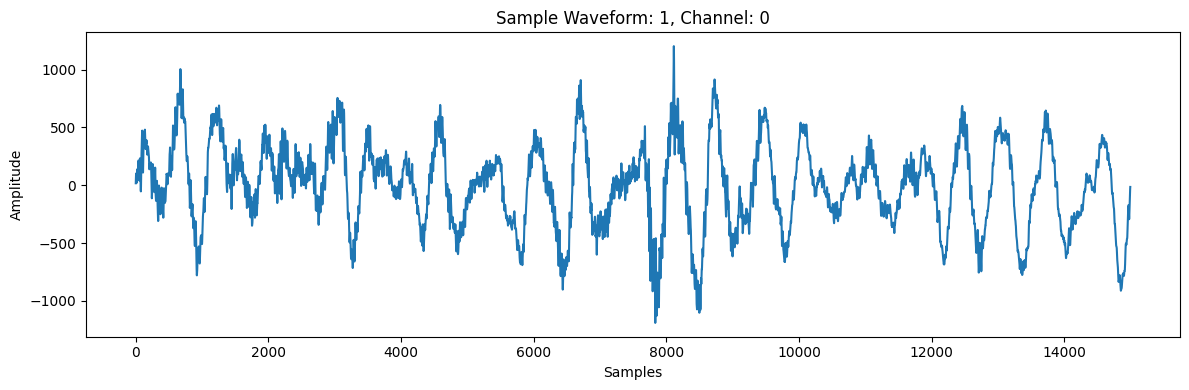

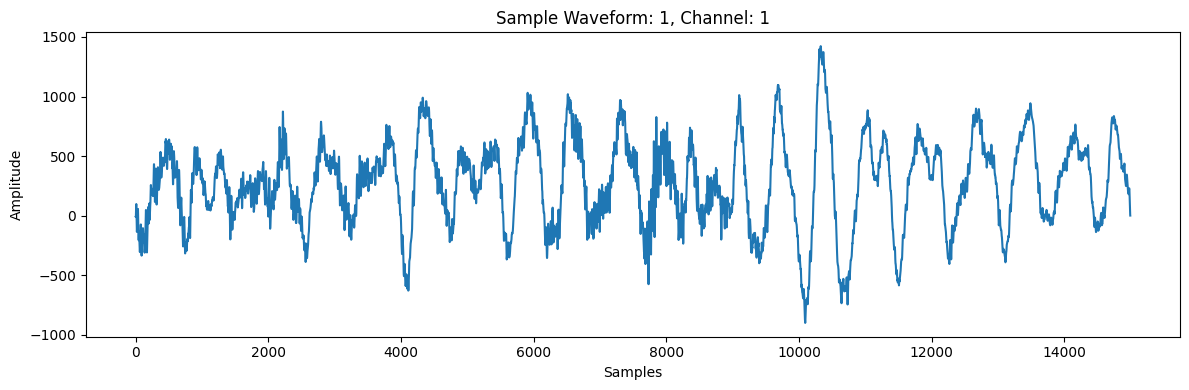

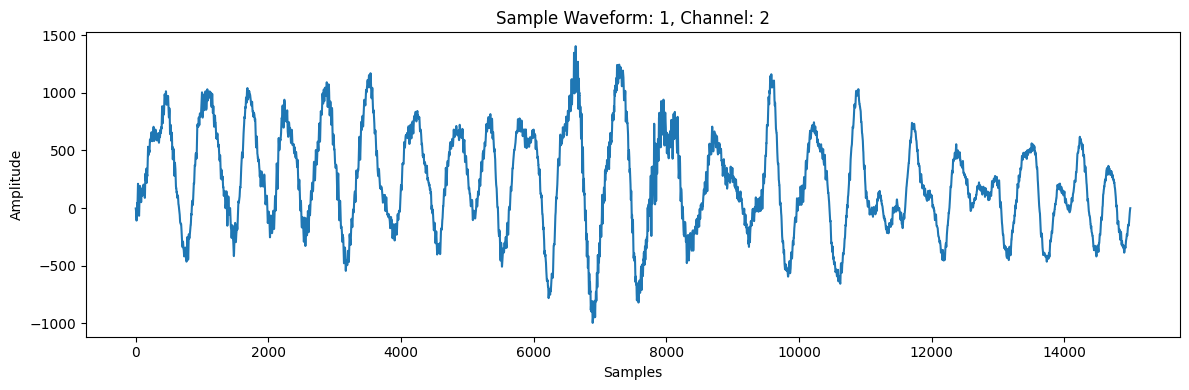

In [144]:
hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        sample_key = list(waveforms_group.keys())[0]
        sample_waveform = waveforms_group[sample_key][:]

        print('samplewaveform shape:', sample_waveform[0].shape)

        for i in range(len(sample_waveform[0])):
            plt.figure(figsize=(12, 4))
            y = sample_waveform[0,i,:]
            x = np.arange(len(y))
            plt.plot(x, y)
            plt.title(f"Sample Waveform: {sample_key}, Channel: {i}")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.show()
        

    

In [149]:
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_test.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_onset,trace_P_onset
0,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,BH,GNW,NaN,47.564130,-122.824980,220.0,"2$0,:3,:14998","2$0,:3,:14998",100,2010-01-01T00:14:27.262282Z,7473,NaN,impulsive,NaN
1,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,BH,HNB,NaN,49.274500,-122.579200,183.0,"9$0,:3,:14998","9$0,:3,:14998",100,2010-01-01T00:15:59.375360Z,8764,7134.0,impulsive,impulsive
2,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,UW,BH,GNW,NaN,47.564130,-122.824980,220.0,"10$0,:3,:14998","10$0,:3,:14998",100,2010-01-01T00:15:59.375360Z,8069,NaN,impulsive,NaN
3,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,UW,BH,PASS,NaN,48.998299,-122.085197,175.4,"1$0,:3,:14998","1$0,:3,:14998",100,2010-01-01T00:15:59.375360Z,7688,6535.0,impulsive,impulsive
4,ev1262330283_689209,2010-01-01T07:18:03.689209Z,47.86208,-122.09903,17799.0,CN,BH,HNB,NaN,49.274500,-122.579200,183.0,"7$0,:3,:14998","7$0,:3,:14998",100,2010-01-01T07:17:13.689209Z,9294,NaN,impulsive,NaN
5,ev1262330283_689209,2010-01-01T07:18:03.689209Z,47.86208,-122.09903,17799.0,UW,BH,GNW,NaN,47.564130,-122.824980,220.0,"5$0,:3,:14998","5$0,:3,:14998",100,2010-01-01T07:17:13.689209Z,6896,NaN,impulsive,NaN
6,ev1262335916_371091,2010-01-01T08:51:56.371091Z,47.96435,-122.91906,21286.0,CN,BH,HNB,NaN,49.274500,-122.579200,183.0,"10$1,:3,:14998","10$1,:3,:14998",100,2010-01-01T08:51:06.371091Z,8908,NaN,impulsive,NaN
7,ev1262362363_83866,2010-01-01T16:12:43.838660Z,45.87262,-122.19180,9822.0,UW,BH,GNW,NaN,47.564130,-122.824980,220.0,"6$0,:3,:14998","6$0,:3,:14998",100,2010-01-01T16:11:53.838660Z,10286,NaN,impulsive,NaN
8,ev1262362363_83866,2010-01-01T16:12:43.838660Z,45.87262,-122.19180,9822.0,UW,BH,YACT,NaN,45.932500,-122.419300,214.0,"9$1,:3,:14998","9$1,:3,:14998",100,2010-01-01T16:11:53.838660Z,5602,5358.0,impulsive,impulsive
9,ev1262369813_218856,2010-01-01T18:16:53.218856Z,48.47626,-123.05830,22641.0,CN,BH,HNB,NaN,49.274500,-122.579200,183.0,"10$2,:3,:14998","10$2,:3,:14998",100,2010-01-01T18:16:03.218856Z,7566,6469.0,impulsive,impulsive


### Verify the test datasets for EH

Keys in HDF5 file:
 - data
f['data'].keys() <KeysViewHDF5 ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']>
 - 0: shape=(6, 1, 14998), min=-6644.83, max=6889.11
 - 1: shape=(12, 1, 14998), min=-1997.19, max=1682.57
 - 10: shape=(4, 1, 14998), min=-107.72, max=74.69
 - 2: shape=(14, 1, 14998), min=-15931.30, max=6947.44
 - 3: shape=(9, 1, 14998), min=-839.04, max=472.25
 - 4: shape=(7, 1, 14998), min=-668.03, max=429.99
 - 5: shape=(8, 1, 14998), min=-470.06, max=319.50
 - 6: shape=(6, 1, 14998), min=-662.63, max=615.04
 - 7: shape=(10, 1, 14998), min=-1299.27, max=1298.92
 - 8: shape=(7, 1, 14998), min=-76.53, max=124.50
 - 9: shape=(7, 1, 14998), min=-515.13, max=504.70
samplewaveform shape: (1, 14998)


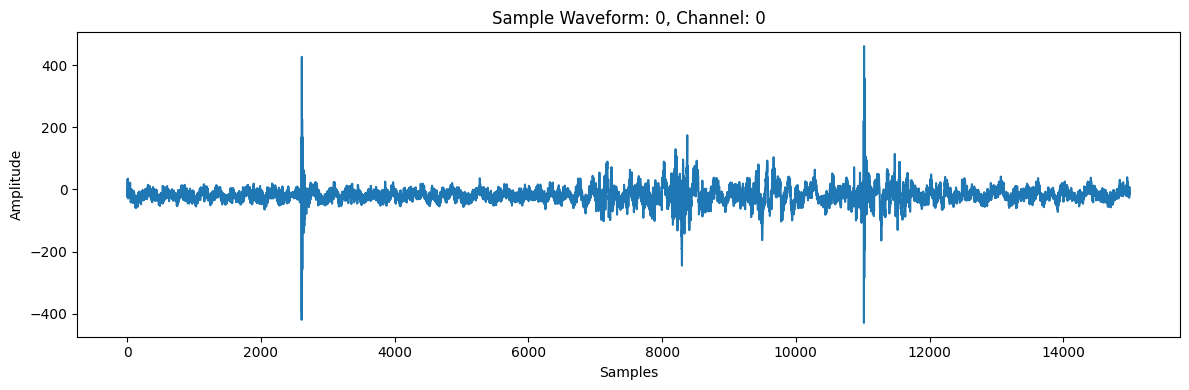

In [145]:
hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_test.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print("f['data'].keys()",f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        sample_key = list(waveforms_group.keys())[0]
        sample_waveform = waveforms_group[sample_key][:]

        print('samplewaveform shape:', sample_waveform[0].shape)

        for i in range(len(sample_waveform[0])):
            plt.figure(figsize=(12, 4))
            y = sample_waveform[0,i,:]
            x = np.arange(len(y))
            plt.plot(x, y)
            plt.title(f"Sample Waveform: {sample_key}, Channel: {i}")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.show()
        


In [148]:
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_onset,trace_P_onset
0,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,PB,EH,B013,NaN,47.813000,-122.910797,75.3,"4$0,:1,:14998","4$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,7635.0,NaN,impulsive,NaN
1,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,PB,EH,B943,NaN,47.813202,-122.911301,84.2,"10$0,:1,:14998","10$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,7650.0,NaN,impulsive,NaN
2,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,BOW,NaN,46.474831,-123.229301,870.0,"10$1,:1,:14998","10$1,:1,:14998",100,2010-01-01T00:14:27.262282Z,8079.0,NaN,impulsive,NaN
3,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,PCMD,NaN,46.888962,-122.301483,239.0,"7$0,:1,:14998","7$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,6601.0,5991.0,impulsive,impulsive
4,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,RVW,NaN,46.149750,-122.742996,504.0,"0$0,:1,:14998","0$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,NaN,7057.0,NaN,impulsive
5,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,BIB,NaN,49.410300,-123.310500,38.0,"2$0,:1,:14998","2$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,9863.0,7772.0,impulsive,impulsive
6,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,GOBB,NaN,48.949300,-123.510500,173.0,"9$0,:1,:14998","9$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,9425.0,7508.0,impulsive,impulsive
7,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,VDB,NaN,49.026100,-122.102800,404.0,"1$0,:1,:14998","1$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,NaN,6577.0,NaN,impulsive
8,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,WPB,NaN,49.647800,-123.209400,260.0,"5$0,:1,:14998","5$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,10283.0,8011.0,impulsive,impulsive
9,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,PB,EH,B001,NaN,48.043072,-123.131409,237.0,"3$0,:1,:14998","3$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,8086.0,6763.0,impulsive,impulsive


In [ ]:
# # Verify the saved H5 file
# import h5py
# import pandas as pd
# output_dir = os.path.expanduser('/wd1/hbito_data/data/datasets_all_regions/seisbench_data')
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# # Path to the generated H5 file
# h5_path = os.path.join(output_dir, '/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test.h5')

# if os.path.exists(h5_path):
#     with h5py.File(h5_path, 'r') as f:
#         # Print basic file information
#         print(f"SeisBench version: {f.attrs.get('seisbench_version')}")
        
#         # List groups
#         print("\nGroups in file:")
#         for group_name in f.keys():
#             print(f" - {group_name}")
        
#         # Print metadata statistics
#         print("\nMetadata statistics:")
#         if 'metadata' in f:
#             metadata_group = f['metadata']
#             for key in metadata_group.keys():
#                 data = metadata_group[key][:]
#                 print(f" - {key}: {len(data)} entries")
                
#             # Convert metadata to DataFrame for viewing
#             metadata_dict = {key: metadata_group[key][:] for key in metadata_group.keys()}
#             metadata_df = pd.DataFrame(metadata_dict)
#             print("\nSample of metadata:")
#             display(metadata_df.head())
        
#         # Print waveform statistics
#         print("\nWaveform statistics:")
#         if 'waveforms' in f:
#             waveforms_group = f['waveforms']
#             print(f" - Number of waveforms: {len(waveforms_group.keys())}")
            
#             # Show information for first few waveforms
#             print("\nSample of waveforms:")
#             for i, key in enumerate(list(waveforms_group.keys())[:5]):
#                 waveform = waveforms_group[key][:]
#                 print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")
                
#             # Plot a sample waveform if matplotlib is available
#             if list(waveforms_group.keys()):
#                 sample_key = list(waveforms_group.keys())[0]
#                 sample_waveform = waveforms_group[sample_key][:]
                
#                 plt.figure(figsize=(12, 4))
#                 plt.plot(sample_waveform)
#                 plt.title(f"Sample Waveform: {sample_key}")
#                 plt.xlabel("Samples")
#                 plt.ylabel("Amplitude")
#                 plt.tight_layout()
#                 plt.show()
# else:
#     print(f"H5 file not found at {h5_path}")
# </VSCode.Cell>

In [ ]:
2010-02-24T12:48:58.323301Z, Trace end: 2010-02-24T12:51:28.323301Z

In [4]:
# Define parameters
network = "CN"
station = "HNB"
location = "*"
channel = "*"  # You can specify e.g. "BH?" or "HH?" if you want specific channels
starttime = obspy.UTCDateTime("2010-02-24T12:48:58.323301Z")
endtime = obspy.UTCDateTime("2010-02-24T12:51:28.323301Z")

# Download waveform
try:
    st = client_iris.get_waveforms(network=network, station=station, location=location, channel=channel,
                                   starttime=starttime, endtime=endtime)
    st.detrend()
    st.plot(equal_scale=False, size=(12, 6), title=f"Waveform for {network}.{station} from {starttime} to {endtime}")
except Exception as e:
    print(f"Error retrieving or plotting waveform: {e}")

Error retrieving or plotting waveform: left cannot be >= right


/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


In [25]:
st_BH_merge_first = st.select(channel="BH?")
# Merge traces with the same channel code
st_BH_merge_first.merge(fill_value='interpolate')

3 Trace(s) in Stream:
CN.HNB..BHE | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:50:53.995000Z | 100.0 Hz, 11568 samples
CN.HNB..BHN | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:51:28.315000Z | 100.0 Hz, 15000 samples
CN.HNB..BHZ | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:51:28.315000Z | 100.0 Hz, 15000 samples

In [26]:
st_BH_merge_first

3 Trace(s) in Stream:
CN.HNB..BHE | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:50:53.995000Z | 100.0 Hz, 11568 samples
CN.HNB..BHN | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:51:28.315000Z | 100.0 Hz, 15000 samples
CN.HNB..BHZ | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:51:28.315000Z | 100.0 Hz, 15000 samples

In [27]:
for i in st:
    print(i)

CN.HNB..BHE | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:49:17.985000Z | 100.0 Hz, 1967 samples
CN.HNB..BHE | 2010-02-24T12:49:48.000000Z - 2010-02-24T12:49:53.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHE | 2010-02-24T12:50:00.000000Z - 2010-02-24T12:50:05.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHE | 2010-02-24T12:50:12.000000Z - 2010-02-24T12:50:17.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHE | 2010-02-24T12:50:30.000000Z - 2010-02-24T12:50:35.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHE | 2010-02-24T12:50:48.000000Z - 2010-02-24T12:50:53.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHN | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:49:17.985000Z | 100.0 Hz, 1967 samples
CN.HNB..BHN | 2010-02-24T12:49:48.000000Z - 2010-02-24T12:49:59.990000Z | 100.0 Hz, 1200 samples
CN.HNB..BHN | 2010-02-24T12:50:12.000000Z - 2010-02-24T12:50:17.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHN | 2010-02-24T12:50:30.000000Z - 2010-02-24T12:50:35.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHN | 2010-02-24T12:50:54.000

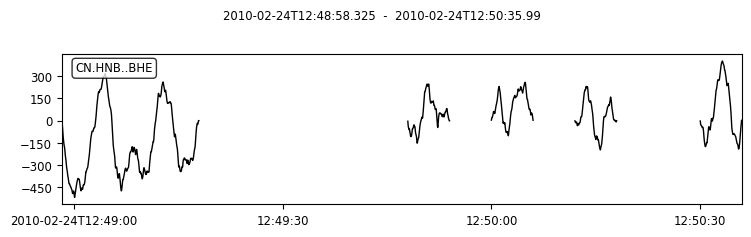

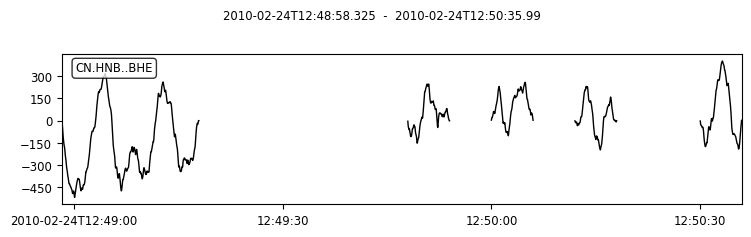

In [28]:
st[0:5].plot()

In [29]:
st_BH_resample_first = st.select(channel="BH?")
# Merge traces with the same channel code
st_BH_resample_first.resample(100)

21 Trace(s) in Stream:

CN.HNB..BHE | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:49:17.985000Z | 100.0 Hz, 1967 samples
...
(19 other traces)
...
CN.HNB..BHZ | 2010-02-24T12:51:24.000000Z - 2010-02-24T12:51:28.310000Z | 100.0 Hz, 432 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [30]:
for i in st_BH_resample_first:
    print(i)

CN.HNB..BHE | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:49:17.985000Z | 100.0 Hz, 1967 samples
CN.HNB..BHE | 2010-02-24T12:49:48.000000Z - 2010-02-24T12:49:53.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHE | 2010-02-24T12:50:00.000000Z - 2010-02-24T12:50:05.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHE | 2010-02-24T12:50:12.000000Z - 2010-02-24T12:50:17.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHE | 2010-02-24T12:50:30.000000Z - 2010-02-24T12:50:35.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHE | 2010-02-24T12:50:48.000000Z - 2010-02-24T12:50:53.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHN | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:49:17.985000Z | 100.0 Hz, 1967 samples
CN.HNB..BHN | 2010-02-24T12:49:48.000000Z - 2010-02-24T12:49:59.990000Z | 100.0 Hz, 1200 samples
CN.HNB..BHN | 2010-02-24T12:50:12.000000Z - 2010-02-24T12:50:17.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHN | 2010-02-24T12:50:30.000000Z - 2010-02-24T12:50:35.990000Z | 100.0 Hz, 600 samples
CN.HNB..BHN | 2010-02-24T12:50:54.000

### Use waveformclient

In [140]:
# Define parameters
network = "CN"
station = "HNB"
location = "*"
channel = "*"  # You can specify e.g. "BH?" or "HH?" if you want specific channels
starttime = obspy.UTCDateTime("2010-02-24T12:48:58.323301Z")
endtime = obspy.UTCDateTime("2010-02-24T12:51:28.323301Z")

# Download waveform
try:
    st = client_iris.get_waveforms(network=network, station=station, location=location, channel=channel,
                                   starttime=starttime, endtime=endtime)
    st.detrend()
    st.plot(equal_scale=False, size=(12, 6), title=f"Waveform for {network}.{station} from {starttime} to {endtime}")
except Exception as e:
    print(f"Error retrieving or plotting waveform: {e}")

Error retrieving or plotting waveform: left cannot be >= right


/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


In [151]:
stream = waveformclient.get_waveforms(network = network,
                                                                station = station,
                                                                location= "*",
                                                                channel = "?H?",
                                                                year    = 2010, doy = starttime.julday,
                                                                starttime = starttime, endtime = endtime)
#stream = stream.trim(trace_start_time, trace_start_time + window_length)
stream.detrend()


21 Trace(s) in Stream:

CN.HNB..BHE | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:49:17.975000Z | 40.0 Hz, 787 samples
...
(19 other traces)
...
CN.HNB..BHZ | 2010-02-24T12:51:24.000000Z - 2010-02-24T12:51:28.325000Z | 40.0 Hz, 174 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


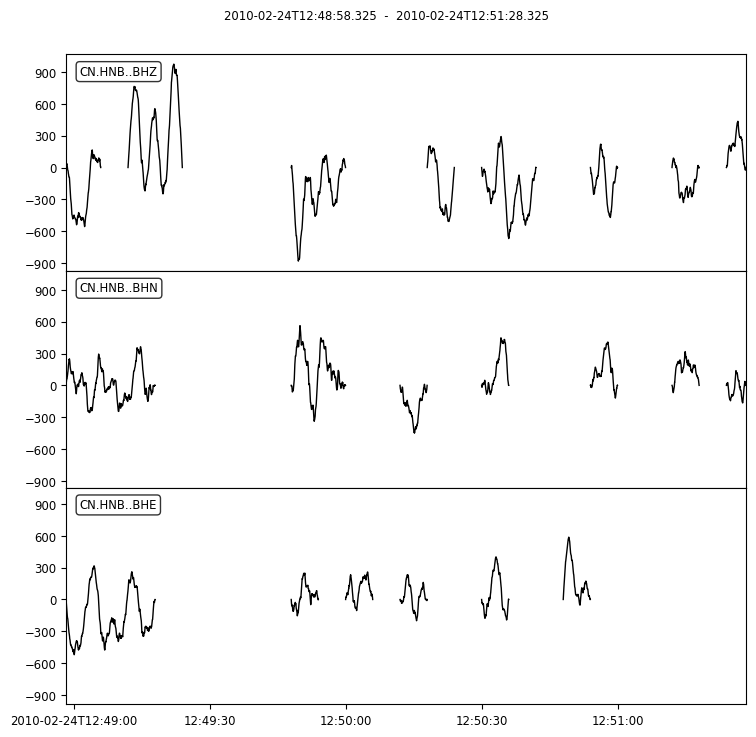

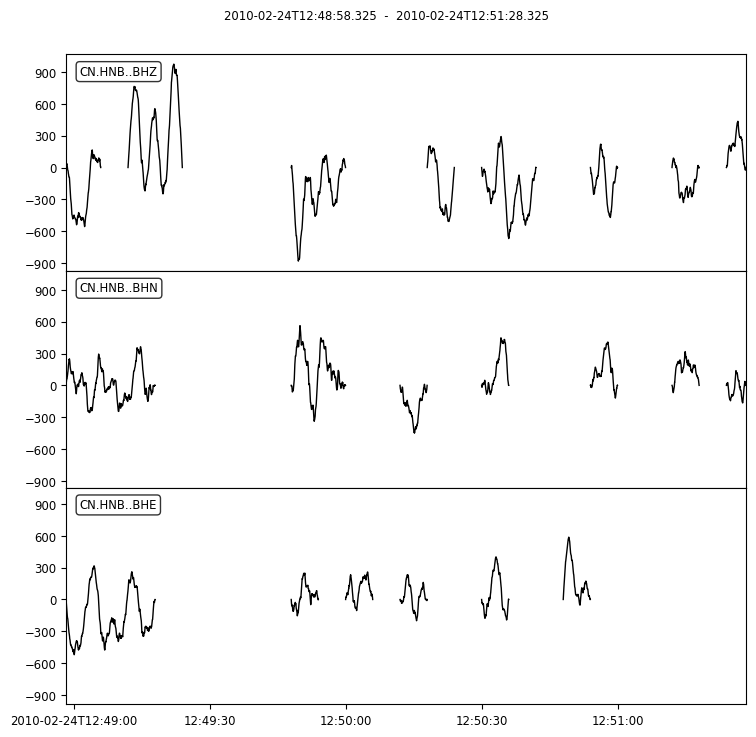

In [152]:
stream.plot()

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


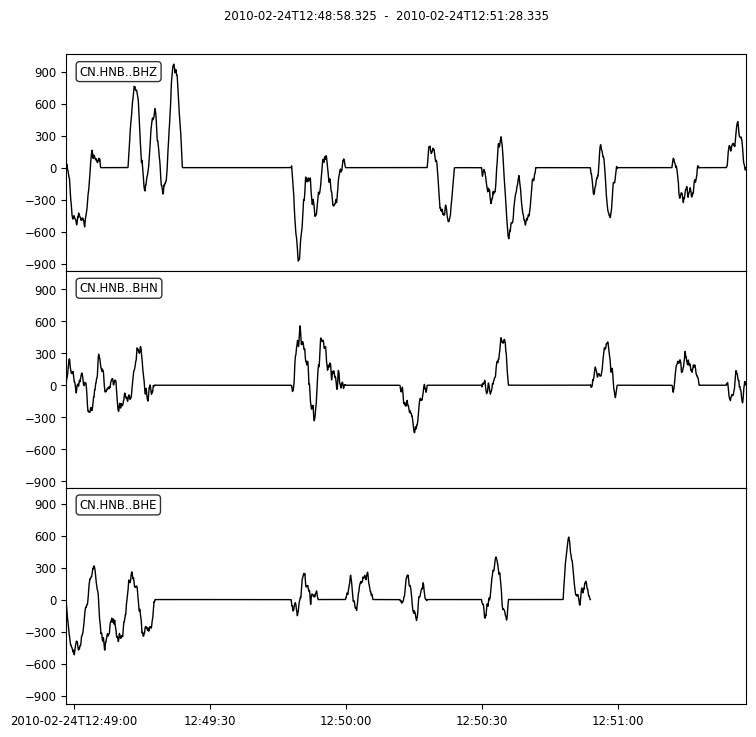

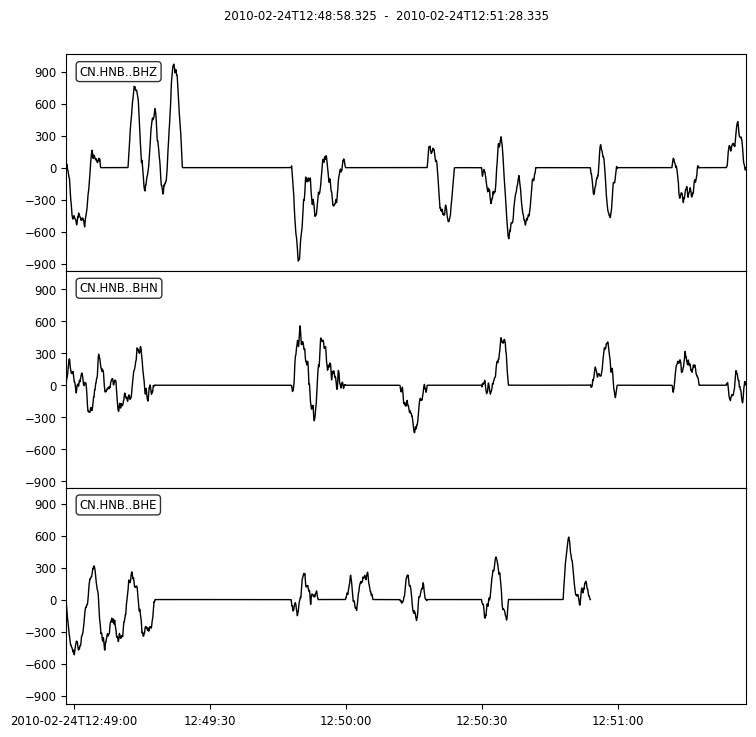

In [ ]:
stream.merge(fill_value='interpolate')
stream.resample(100)
stream.plot()


/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


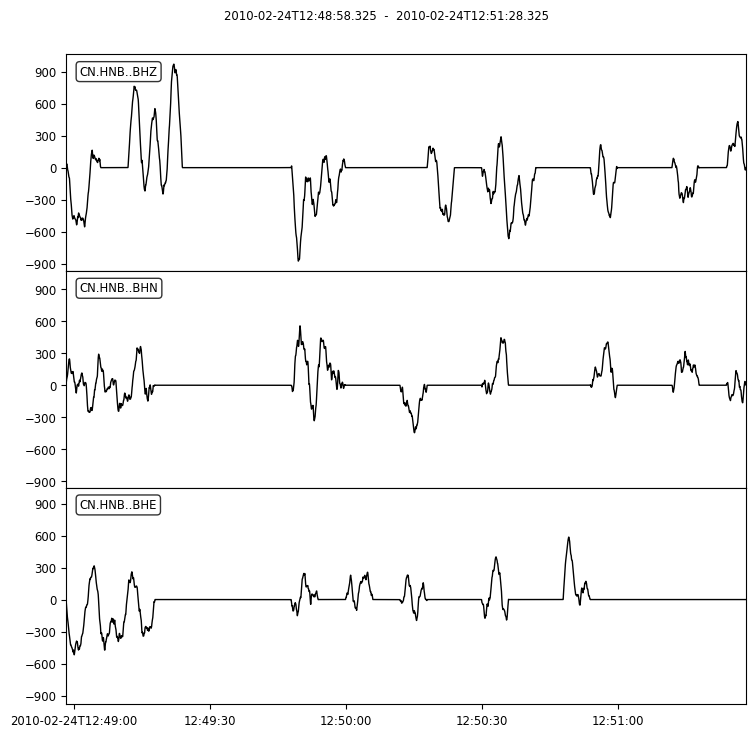

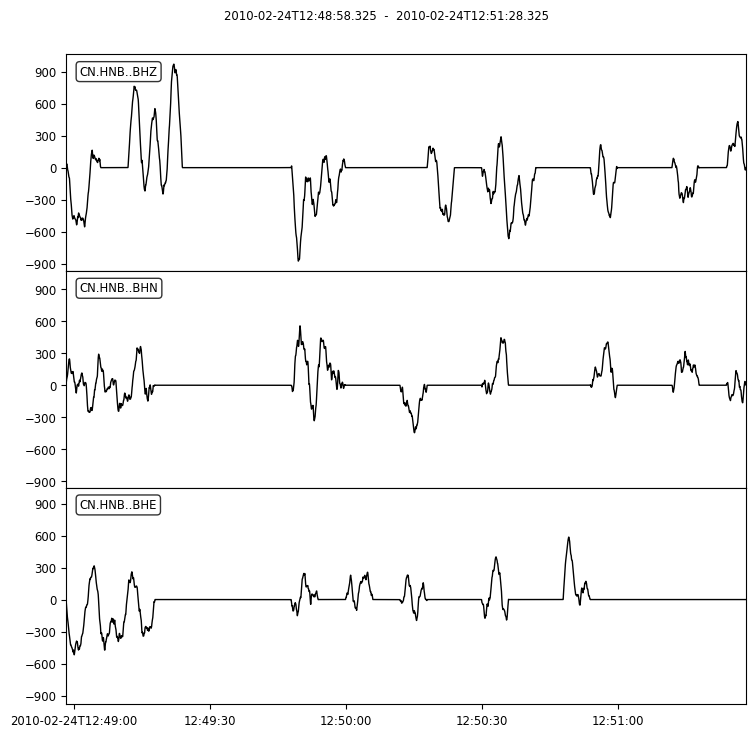

In [150]:
stream.trim(starttime, endtime, pad=True, fill_value=0)
stream.plot()

In [5]:
# List rows with network 'BK'
bk_rows = assoc_df[assoc_df['sta'].str.startswith('BK.')]


In [5]:
bk_rows.iloc[10][['sta', 'iphase', 'otime', 'lat', 'lon', 'depth']]

sta                  BK.JCC
iphase                    P
otime     1294314916.618399
lat                40.32492
lon              -124.88467
depth                27.552
Name: 121015, dtype: object

In [74]:
bk_rows.iloc[10].pick_time

1294314930.318391

## Test stations on ncedc stations

In [ ]:
# Define parameters
network = "BK"
station = "JCC"
location = "*"
channel = "*"  # You can specify e.g. "BH?" or "HH?" if you want specific channels
starttime = obspy.UTCDateTime()
endtime = starttime + timedelta(seconds=150)  # 150 seconds after the first arrival

# Download waveform
try:
    st = client_iris.get_waveforms(network=network, station=station, location=location, channel=channel,
                                   starttime=starttime, endtime=endtime)
    st.detrend()
    st.plot(equal_scale=False, size=(12, 6), title=f"Waveform for {network}.{station} from {starttime} to {endtime}")
except Exception as e:
    print(f"Error retrieving or plotting waveform: {e}")

Error retrieving or plotting waveform: No data available for request.
HTTP Status code: 204
Detailed response of server:




### Test WaveformCLients on NCEDC and 7D stations

In [ ]:
# Define parameters
network = "BK"
station = "JCC"
location = "*"
channel = "*"  # You can specify e.g. "BH?" or "HH?" if you want specific channels
starttime = obspy.UTCDateTime(bk_rows.iloc[0].pick_time)
endtime = starttime + timedelta(seconds=150)  # 150 seconds after the first arrival

stream = waveformclient.get_waveforms(network = network,
                                                                station = station,
                                                                location= "*",
                                                                channel = "?H?",
                                                                year    = 2010, doy = starttime.julday,
                                                                starttime = starttime, endtime = endtime)
#stream = stream.trim(trace_start_time, trace_start_time + window_length)
stream.detrend()


0 Trace(s) in Stream:


In [50]:
starttime

2011-01-06T04:30:04.558391Z

In [51]:
client_ncedc = Client('NCEDC')
stream = client_ncedc.get_waveforms(network = network,
                                                                station = station,
                                                                location= "*",
                                                                channel = "?H?",
                                                                starttime = starttime, endtime = endtime)
stream.detrend()
stream.merge(fill_value='interpolate')
stream.resample(100)

12 Trace(s) in Stream:
BK.JCC.00.BHE | 2011-01-06T04:30:04.569538Z - 2011-01-06T04:32:34.559538Z | 100.0 Hz, 15000 samples
BK.JCC.00.BHN | 2011-01-06T04:30:04.569536Z - 2011-01-06T04:32:34.559536Z | 100.0 Hz, 15000 samples
BK.JCC.00.BHZ | 2011-01-06T04:30:04.569536Z - 2011-01-06T04:32:34.559536Z | 100.0 Hz, 15000 samples
BK.JCC.00.HHE | 2011-01-06T04:30:04.568391Z - 2011-01-06T04:32:34.558391Z | 100.0 Hz, 15000 samples
BK.JCC.00.HHN | 2011-01-06T04:30:04.568391Z - 2011-01-06T04:32:34.558391Z | 100.0 Hz, 15000 samples
BK.JCC.00.HHZ | 2011-01-06T04:30:04.568391Z - 2011-01-06T04:32:34.558391Z | 100.0 Hz, 15000 samples
BK.JCC.00.LHE | 2011-01-06T04:30:05.069538Z - 2011-01-06T04:32:35.059538Z | 100.0 Hz, 15000 samples
BK.JCC.00.LHN | 2011-01-06T04:30:05.069538Z - 2011-01-06T04:32:35.059538Z | 100.0 Hz, 15000 samples
BK.JCC.00.LHZ | 2011-01-06T04:30:05.069536Z - 2011-01-06T04:32:35.059536Z | 100.0 Hz, 15000 samples
BK.JCC.00.VHE | 2011-01-06T04:30:10.069536Z - 2011-01-06T04:32:40.059536Z | 1

In [84]:
client_waveform = WaveformClient()

In [81]:
# Get waveforms and filter
# NTS: This sampling scheme leans heavily on prior data QC going into PNW store
network = "BK"
station = "JCC"
location = "*"
channels = "*"  # You can specify e.g. "BH?" or "HH?" if you want specific channels
t1 = obspy.UTCDateTime(bk_rows.iloc[0].pick_time) # Example start time
t2 = starttime + timedelta(seconds=150)  # Example end time, 150 seconds after the first arrival      

try:
    if network in ['NC', 'BK']:
        # Query waveforms
        _sdata = client_ncedc.get_waveforms(network=network, station=station, location="*", channel=channels,
                                            starttime= t1, endtime= t2)
    else:
        # Shouldn't this have an explicit starttime + endtime inputs?
        _sdata = client_waveform.get_waveforms(network=network, station=station, channel=channels, 
                                            year=t1.strftime('%Y'), month=t1.strftime('%m'), 
                                            day=t1.strftime('%d'))
except obspy.clients.fdsn.header.FDSNNoDataException:
    print(f"WARNING: No data for {network}.{station}.{channels} on {t1} - {t2}.")

_sdata

29 Trace(s) in Stream:

BK.JCC.00.BHE | 2011-01-06T04:30:04.569538Z - 2011-01-06T04:32:34.544538Z | 40.0 Hz, 6000 samples
...
(27 other traces)
...
BK.JCC.00.VMW | 2011-01-06T04:30:10.000000Z - 2011-01-06T04:32:30.000000Z | 0.1 Hz, 15 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [65]:
obspy.UTCDateTime(bk_rows.iloc[0].pick_time)

2011-01-06T04:30:04.558391Z

In [77]:
t1 

2011-01-06T11:55:30.318391Z

### Test the script with BK stations

In [6]:
bk_rows

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,lon,depth,otime,nass,p_picks,s_picks,rms,nsphz,gap,algorithm
120897,BK.JCC,1.294288e+09,120897,P,0.863,8508,P,0.117,40.817451,-124.029549,...,-124.56471,17.623,1.294288e+09,22,12,10,0.643,10.0,260.126582,genie
120934,BK.JCC,1.294293e+09,120934,P,0.706,8511,P,-0.438,40.817451,-124.029549,...,-124.28544,14.092,1.294293e+09,14,7,7,0.227,7.0,210.833678,genie
120946,BK.JCC,1.294295e+09,120946,P,0.646,8512,P,-0.199,40.817451,-124.029549,...,-124.21149,13.675,1.294295e+09,8,4,4,0.147,4.0,187.676992,genie
120951,BK.JCC,1.294302e+09,120951,P,0.608,8513,P,-0.058,40.817451,-124.029549,...,-124.57689,9.402,1.294302e+09,5,1,4,0.357,4.0,283.368790,genie
120959,BK.JCC,1.294309e+09,120959,P,0.763,8514,P,-0.277,40.817451,-124.029549,...,-124.28715,13.793,1.294309e+09,10,5,5,0.219,5.0,211.823571,genie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003911,BK.JCC,1.435053e+09,1003911,S,0.733,63860,S,1.380,40.817451,-124.029549,...,-124.91113,25.160,1.435053e+09,8,1,7,1.528,7.0,90.180756,genie
1004022,BK.JCC,1.435068e+09,1004022,P,0.676,63867,P,0.613,40.817451,-124.029549,...,-124.99601,18.596,1.435068e+09,25,5,20,0.933,20.0,159.106064,genie
1004036,BK.JCC,1.435068e+09,1004036,S,0.676,63867,S,-0.344,40.817451,-124.029549,...,-124.99601,18.596,1.435068e+09,25,5,20,0.933,20.0,159.106064,genie
1004277,BK.JCC,1.435097e+09,1004277,P,0.654,63882,P,1.069,40.817451,-124.029549,...,-124.42438,19.741,1.435097e+09,23,9,14,1.015,14.0,73.959960,genie


In [6]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test_BK_NC.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_test_BK_NC.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_test_BK_NC.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test_BK_NC.csv"

# Extract network and station from sta column
df = bk_rows.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)

# Set constants
sampling_rate = 100  # Hz
pre_arrival_time = 50  # time before the first arrival in seconds
window_length = 150  # time window length in seconds

# Create a unique event ID for each unique time
# This assumes different events have different timestamps
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

# Create 10 buckets the hdf5 file
waveform_buckets_HH_BH = {str(i): [] for i in range(11)}  # 0 to 10
waveform_buckets_EH = {str(i): [] for i in range(11)}  # 0 to 10

# Group by event_id, network and station to combine P and S arrivals
rows_HH_BH = []
rows_EH = []

group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 20):
    # Find P and S arrivals
    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")
        
    
    # Calculate trace start time (50 seconds before the first arrival)
    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time  # 50 seconds before the first arrival
    trace_end = trace_start + window_length  # 100 seconds after the first arrival

    # Convert to UTCDateTime
#     trace_start1 = obspy.UTCDateTime(trace_start).strftime('%Y-%m-%dT%H:%M:%S')
#     trace_end1 = obspy.UTCDateTime(trace_end).strftime('%Y-%m-%dT%H:%M:%S')
    ##################################################
    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)
    ##################################################
    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    # download the waveform data

    try: 
        sta = client_iris.get_stations(network=network, station=station,location="*",channel="*", \
                                    starttime=trace_start1 , endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing station info:", e)

    except Exception as e:
        print("Error during download or processing waveforms:", e)

    try:
        if network in ['NC', 'BK']:
            # Query waveforms
            _waveform = client_ncedc.get_waveforms(network=network, station=station, location="*", channel="*",
                                                starttime= trace_start1, endtime= trace_end1)
        else:
            # Shouldn't this have an explicit starttime + endtime inputs?
            _waveform = client_waveform.get_waveforms(network = network,
                                                    station = station,
                                                    location= "*",
                                                    channel = "?H?",
                                                    starttime = trace_start1, endtime = trace_end1)
    except Exception as e:
        print("Error during download or processing:", e)

    # Detrend
    _waveform.detrend()
    # Resample the waveform traces to 100 Hz
    _waveform.resample(100)
    # Interpolate missing data
    _waveform.merge(method=1,fill_value='interpolate')
    # Fill the gaps at the start and end of the stream
    _waveform.trim(trace_start1, trace_end1, pad=True, fill_value=0)

    
    # Store the origin data 
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0]*1000

    # Store the station metadata
    slat = sta[0][0].latitude 
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    # Create a new stream
    waveform = Stream()

    # Check if loaded data have a vertical component (minimum requirement)
    has_Z = bool(_waveform.select(channel='??Z'))

    # Check for channels presence
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    # If no vertical component is present, skip this pick
    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue
    
   # Apply selection logic based on channel presence
    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    print(f"Number of traces: {len(waveform)}")

    # # Check if the stream have 3-component data
    # if len(waveform) != 3:
    #         continue
    
    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)    


    # Print trace information
    for i, tr in enumerate(waveform):
        
        print(f"Trace {i}: id={tr.id}, tr.stats.channel={tr.stats.channel}, data shape={tr.data.shape}")

    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    # Obtain the channel code
    station_channel_code = waveform[0].stats.channel[:-1]

    # Stack the traces into a array
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)  # (3, T)
    
    # Determine the shape of the data
    num_trs = data.shape[0]
    num_tps = data.shape[1]
    
    # # save the waveform data to a seisbench format
    # h5_file = f"{network}.{station}..HHZ.{trace_start.strftime('%Y%m%dT%H%M%S')}.h5"
    # waveform.write(h5_file, format='HDF5')

    
    # Calculate P and S samples
    p_sample = None
    if not p_arrival.empty:
        p_time = p_arrival['pick_time'].iloc[0]
        p_sample = int((p_time - trace_start) * sampling_rate)
    
    s_sample = None
    if not s_arrival.empty:
        s_time = s_arrival['pick_time'].iloc[0]
        s_sample = int((s_time - trace_start) * sampling_rate)
    
    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")

/tmp/ipykernel_1083924/921492507.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


No S arrival for event ev1294288193_014992 at station JCC
Trace start: 2011-01-06T04:29:03.014992Z, Trace end: 2011-01-06T04:31:33.014992Z
Number of traces: 3
Trace 0: id=BK.JCC.00.HHE, tr.stats.channel=HHE, data shape=(15001,)
Trace 1: id=BK.JCC.00.HHN, tr.stats.channel=HHN, data shape=(15001,)
Trace 2: id=BK.JCC.00.HHZ, tr.stats.channel=HHZ, data shape=(15001,)
No S arrival for event ev1294293162_942228 at station JCC
Trace start: 2011-01-06T05:51:52.942228Z, Trace end: 2011-01-06T05:54:22.942228Z
Number of traces: 3
Trace 0: id=BK.JCC.00.HHE, tr.stats.channel=HHE, data shape=(15001,)
Trace 1: id=BK.JCC.00.HHN, tr.stats.channel=HHN, data shape=(15001,)
Trace 2: id=BK.JCC.00.HHZ, tr.stats.channel=HHZ, data shape=(15001,)
No S arrival for event ev1294295275_237561 at station JCC
Trace start: 2011-01-06T06:27:05.237561Z, Trace end: 2011-01-06T06:29:35.237561Z
Number of traces: 3
Trace 0: id=BK.JCC.00.HHE, tr.stats.channel=HHE, data shape=(15001,)
Trace 1: id=BK.JCC.00.HHN, tr.stats.chan

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['0', '1', '10', '3', '4', '6', '7', '8', '9']>
 - 0: shape=(4, 3, 14998), min=-10393.33, max=12161.15
 - 1: shape=(1, 3, 14998), min=-7822.25, max=5698.49
 - 10: shape=(1, 3, 14998), min=-6270.72, max=8965.99
 - 3: shape=(2, 3, 14998), min=-8145.87, max=10025.72
 - 4: shape=(2, 3, 14998), min=-33040.98, max=25730.23
 - 6: shape=(2, 3, 14998), min=-8579.19, max=10412.73
 - 7: shape=(4, 3, 14998), min=-30829.95, max=30866.81
 - 8: shape=(2, 3, 14998), min=-9289.66, max=12563.77
 - 9: shape=(2, 3, 14998), min=-18618.79, max=11667.59
samplewaveform shape: (3, 14998)


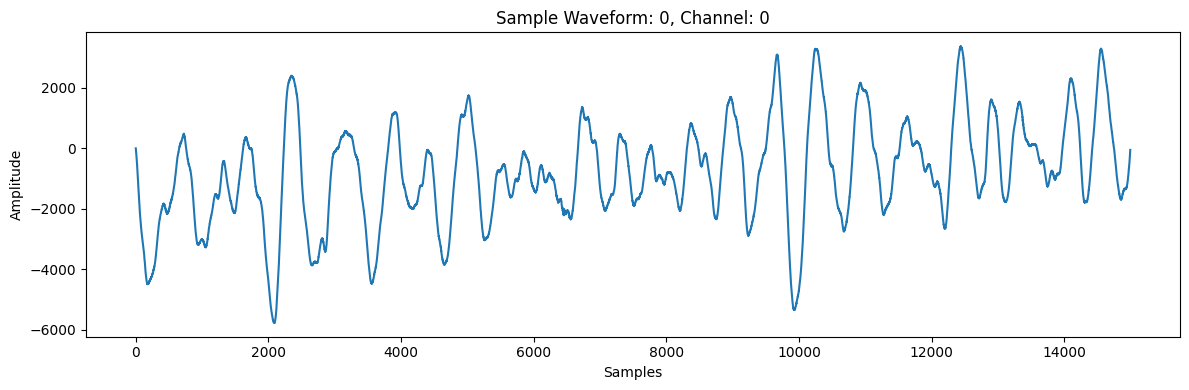

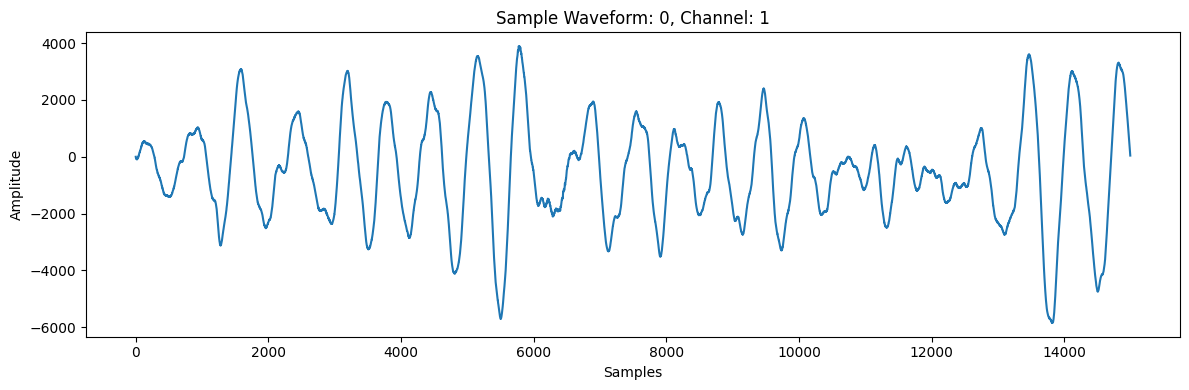

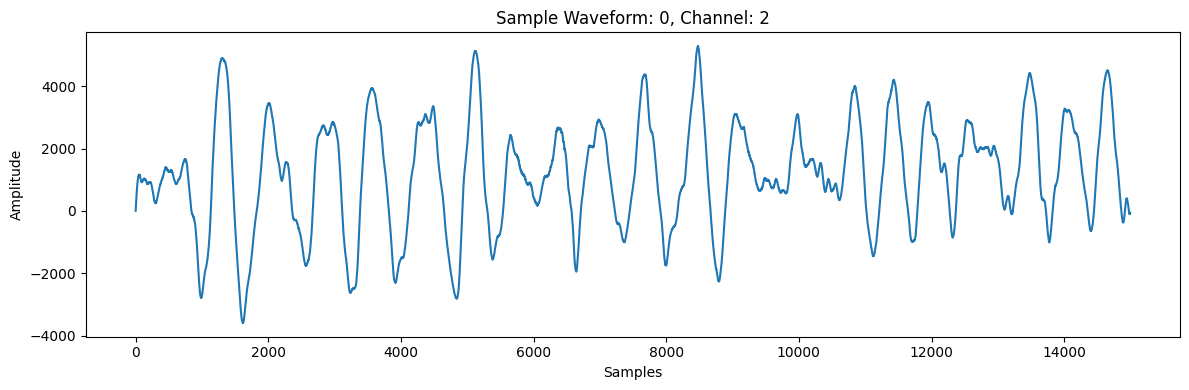

In [8]:
hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test_BK_NC.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        sample_key = list(waveforms_group.keys())[0]
        sample_waveform = waveforms_group[sample_key][:]

        print('samplewaveform shape:', sample_waveform[0].shape)

        for i in range(len(sample_waveform[0])):
            plt.figure(figsize=(12, 4))
            y = sample_waveform[0,i,:]
            x = np.arange(len(y))
            plt.plot(x, y)
            plt.title(f"Sample Waveform: {sample_key}, Channel: {i}")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.show()
        

    

In [9]:
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_test_BK_NC.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_onset,trace_P_onset
0,ev1294288193_014992,2011-01-06T04:29:53.014992Z,40.31143,-124.56471,17623.0,BK,HH,JCC,NaN,40.817451,-124.029549,27.2,"7$0,:3,:14998","7$0,:3,:14998",100,2011-01-06T04:29:03.014992Z,NaN,6154.0,NaN,impulsive
1,ev1294293162_942228,2011-01-06T05:52:42.942228Z,40.48588,-124.28544,14092.0,BK,HH,JCC,NaN,40.817451,-124.029549,27.2,"0$0,:3,:14998","0$0,:3,:14998",100,2011-01-06T05:51:52.942228Z,NaN,5758.0,NaN,impulsive
2,ev1294295275_237561,2011-01-06T06:27:55.237561Z,40.50885,-124.21149,13675.0,BK,HH,JCC,NaN,40.817451,-124.029549,27.2,"3$0,:3,:14998","3$0,:3,:14998",100,2011-01-06T06:27:05.237561Z,NaN,5684.0,NaN,impulsive
3,ev1294301678_28882,2011-01-06T08:14:38.288820Z,40.67203,-124.57689,9402.0,BK,HH,JCC,NaN,40.817451,-124.029549,27.2,"8$0,:3,:14998","8$0,:3,:14998",100,2011-01-06T08:13:48.288820Z,NaN,5843.0,NaN,impulsive
4,ev1294309030_960963,2011-01-06T10:17:10.960963Z,40.49097,-124.28715,13793.0,BK,HH,JCC,NaN,40.817451,-124.029549,27.2,"9$0,:3,:14998","9$0,:3,:14998",100,2011-01-06T10:16:20.960963Z,NaN,5749.0,NaN,impulsive
5,ev1294310811_630984,2011-01-06T10:46:51.630984Z,40.61033,-124.01280,18381.0,BK,HH,JCC,NaN,40.817451,-124.029549,27.2,"6$0,:3,:14998","6$0,:3,:14998",100,2011-01-06T10:46:01.630984Z,5968.0,NaN,impulsive,NaN
6,ev1294311103_522631,2011-01-06T10:51:43.522631Z,40.48661,-124.28752,14079.0,BK,HH,JCC,NaN,40.817451,-124.029549,27.2,"0$1,:3,:14998","0$1,:3,:14998",100,2011-01-06T10:50:53.522631Z,6404.0,5758.0,impulsive,impulsive
7,ev1294311934_002427,2011-01-06T11:05:34.002427Z,40.40363,-123.89723,20985.0,BK,HH,JCC,NaN,40.817451,-124.029549,27.2,"1$0,:3,:14998","1$0,:3,:14998",100,2011-01-06T11:04:44.002427Z,6530.0,5868.0,impulsive,impulsive
8,ev1294314916_618399,2011-01-06T11:55:16.618399Z,40.32492,-124.88467,27552.0,BK,HH,JCC,NaN,40.817451,-124.029549,27.2,"10$0,:3,:14998","10$0,:3,:14998",100,2011-01-06T11:54:26.618399Z,7417.0,6369.0,impulsive,impulsive
9,ev1294315684_360198,2011-01-06T12:08:04.360198Z,40.35093,-124.38521,11304.0,BK,HH,JCC,NaN,40.817451,-124.029549,27.2,"9$1,:3,:14998","9$1,:3,:14998",100,2011-01-06T12:07:14.360198Z,6782.0,6011.0,impulsive,impulsive


In [8]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test_iris.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_test_iris.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_test_iris.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test_iris.csv"

# Extract network and station from sta column
df = assoc_df.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)

# Set constants
sampling_rate = 100  # Hz
pre_arrival_time = 50  # time before the first arrival in seconds
window_length = 150  # time window length in seconds

# Create a unique event ID for each unique time
# This assumes different events have different timestamps
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

# Create 10 buckets the hdf5 file
waveform_buckets_HH_BH = {str(i): [] for i in range(11)}  # 0 to 10
waveform_buckets_EH = {str(i): [] for i in range(11)}  # 0 to 10

# Group by event_id, network and station to combine P and S arrivals
rows_HH_BH = []
rows_EH = []

group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 20):
    # Find P and S arrivals
    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")
        
    
    # Calculate trace start time (50 seconds before the first arrival)
    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time  # 50 seconds before the first arrival
    trace_end = trace_start + window_length  # 100 seconds after the first arrival

    # Convert to UTCDateTime
#     trace_start1 = obspy.UTCDateTime(trace_start).strftime('%Y-%m-%dT%H:%M:%S')
#     trace_end1 = obspy.UTCDateTime(trace_end).strftime('%Y-%m-%dT%H:%M:%S')
    ##################################################
    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)
    ##################################################
    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    # download the waveform data

    try: 
        sta = client_iris.get_stations(network=network, station=station,location="*",channel="*", \
                                    starttime=trace_start1 , endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing station info:", e)

    try:
        if network in ['NC', 'BK']:
            # Query waveforms
            _waveform = client_ncedc.get_waveforms(network=network, station=station, location="*", channel="*",
                                                starttime= trace_start1, endtime= trace_end1)
        else:
            # Shouldn't this have an explicit starttime + endtime inputs?
            _waveform = client_waveform.get_waveforms(network = network,
                                                    station = station,
                                                    location= "*",
                                                    channel = "?H?",
                                                    starttime = trace_start1, endtime = trace_end1)
    except Exception as e:
        print("Error during download or processing:", e)

    # Detrend
    _waveform.detrend()
    # Resample the waveform traces to 100 Hz
    _waveform.resample(100)
    # Interpolate missing data
    _waveform.merge(method=1,fill_value='interpolate')
    # Fill the gaps at the start and end of the stream
    _waveform.trim(trace_start1, trace_end1, pad=True, fill_value=0)

    
    # Store the origin data 
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0]*1000

    # Store the station metadata
    slat = sta[0][0].latitude 
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    # Create a new stream
    waveform = Stream()

    # Check if loaded data have a vertical component (minimum requirement)
    has_Z = bool(_waveform.select(channel='??Z'))

    # Check for channels presence
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    # If no vertical component is present, skip this pick
    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue
    
   # Apply selection logic based on channel presence
    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    print(f"Number of traces: {len(waveform)}")

    # # Check if the stream have 3-component data
    # if len(waveform) != 3:
    #         continue
    
    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)    


    # Print trace information
    for i, tr in enumerate(waveform):
        
        print(f"Trace {i}: id={tr.id}, tr.stats.channel={tr.stats.channel}, data shape={tr.data.shape}")

    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    # Obtain the channel code
    station_channel_code = waveform[0].stats.channel[:-1]

    # Stack the traces into a array
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)  # (3, T)
    
    # Determine the shape of the data
    num_trs = data.shape[0]
    num_tps = data.shape[1]
    
    # # save the waveform data to a seisbench format
    # h5_file = f"{network}.{station}..HHZ.{trace_start.strftime('%Y%m%dT%H%M%S')}.h5"
    # waveform.write(h5_file, format='HDF5')

    
    # Calculate P and S samples
    p_sample = None
    if not p_arrival.empty:
        p_time = p_arrival['pick_time'].iloc[0]
        p_sample = int((p_time - trace_start) * sampling_rate)
    
    s_sample = None
    if not s_arrival.empty:
        s_time = s_arrival['pick_time'].iloc[0]
        s_sample = int((s_time - trace_start) * sampling_rate)
    
    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")

/tmp/ipykernel_1085424/536481680.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 1
Trace 0: id=PB.B013..EHZ, tr.stats.channel=EHZ, data shape=(15001,)
EH bucket: 1
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 1
Trace 0: id=PB.B943..EHZ, tr.stats.channel=EHZ, data shape=(15001,)
EH bucket: 2
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 1
Trace 0: id=UW.BOW..EHZ, tr.stats.channel=EHZ, data shape=(15001,)
EH bucket: 2
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 3
Trace 0: id=UW.GNW..BHE, tr.stats.channel=BHE, data shape=(15001,)
Trace 1: id=UW.GNW..BHN, tr.stats.channel=BHN, data shape=(15001,)
Trace 2: id=UW.GNW..BHZ, tr.stats.channel=BHZ, data shape=(15001,)
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 1
Trace 0: id=UW.PCMD..EHZ, tr.stats.channel=EHZ, data

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['0', '1', '10', '2', '3', '4', '5', '6', '8', '9']>
 - 0: shape=(1, 1, 14998), min=-44.86, max=40.57
 - 1: shape=(1, 1, 14998), min=-104.35, max=74.91
 - 10: shape=(3, 1, 14998), min=-156.11, max=146.38
 - 2: shape=(2, 1, 14998), min=-70.79, max=104.96
 - 3: shape=(2, 1, 14998), min=-490.50, max=460.79
 - 4: shape=(2, 1, 14998), min=-91.95, max=86.74
 - 5: shape=(2, 1, 14998), min=-57.34, max=74.82
 - 6: shape=(1, 1, 14998), min=-1372.71, max=1034.46
 - 8: shape=(1, 1, 14998), min=-48.87, max=71.39
 - 9: shape=(3, 1, 14998), min=-351.50, max=227.53
samplewaveform shape: (1, 14998)


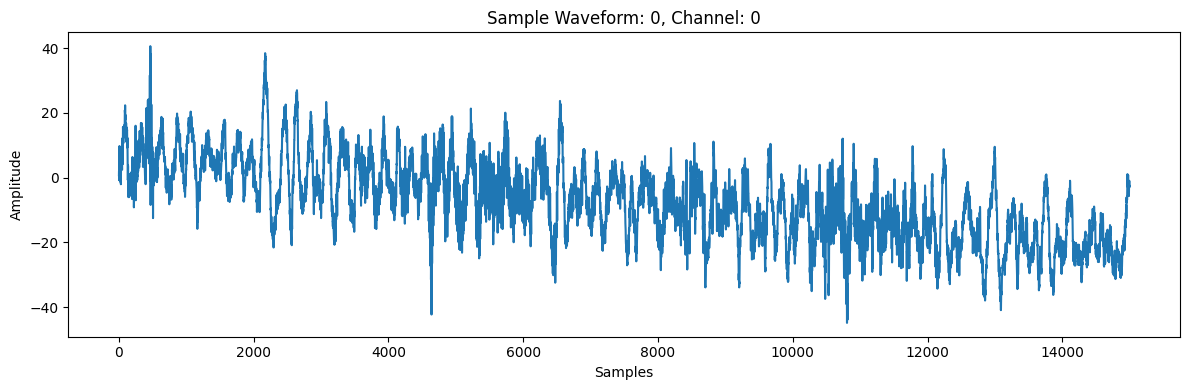

In [11]:
hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_test_iris.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        sample_key = list(waveforms_group.keys())[0]
        sample_waveform = waveforms_group[sample_key][:]

        print('samplewaveform shape:', sample_waveform[0].shape)

        for i in range(len(sample_waveform[0])):
            plt.figure(figsize=(12, 4))
            y = sample_waveform[0,i,:]
            x = np.arange(len(y))
            plt.plot(x, y)
            plt.title(f"Sample Waveform: {sample_key}, Channel: {i}")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.show()
        

    

In [12]:
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test_iris.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_onset,trace_P_onset
0,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,PB,EH,B013,NaN,47.813000,-122.910797,75.3,"4$0,:1,:14998","4$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,7635.0,NaN,impulsive,NaN
1,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,PB,EH,B943,NaN,47.813202,-122.911301,84.2,"5$0,:1,:14998","5$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,7650.0,NaN,impulsive,NaN
2,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,BOW,NaN,46.474831,-123.229301,870.0,"1$0,:1,:14998","1$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,8079.0,NaN,impulsive,NaN
3,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,PCMD,NaN,46.888962,-122.301483,239.0,"6$0,:1,:14998","6$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,6601.0,5991.0,impulsive,impulsive
4,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,RVW,NaN,46.149750,-122.742996,504.0,"3$0,:1,:14998","3$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,NaN,7057.0,NaN,impulsive
5,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,BIB,NaN,49.410300,-123.310500,38.0,"10$0,:1,:14998","10$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,9863.0,7772.0,impulsive,impulsive
6,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,GOBB,NaN,48.949300,-123.510500,173.0,"3$1,:1,:14998","3$1,:1,:14998",100,2010-01-01T00:15:59.375360Z,9425.0,7508.0,impulsive,impulsive
7,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,VDB,NaN,49.026100,-122.102800,404.0,"9$0,:1,:14998","9$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,NaN,6577.0,NaN,impulsive
8,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,WPB,NaN,49.647800,-123.209400,260.0,"9$1,:1,:14998","9$1,:1,:14998",100,2010-01-01T00:15:59.375360Z,10283.0,8011.0,impulsive,impulsive
9,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,PB,EH,B001,NaN,48.043072,-123.131409,237.0,"2$0,:1,:14998","2$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,8086.0,6763.0,impulsive,impulsive


In [23]:
# Find rows in assoc_df where pick_time is close to 23:59 (within 1 minute)
# Convert pick_time (epoch) to datetime if not already present
if 'datetime' not in assoc_df.columns:
    assoc_df['datetime'] = pd.to_datetime(assoc_df['pick_time'], unit='s')

# Find rows where the time is close to 23:59 (within 1 minute)
mask = assoc_df['datetime'].dt.time.between(pd.to_datetime('23:58:00').time(), pd.to_datetime('23:59:59').time())
close_to_midnight = assoc_df[mask]
close_to_midnight[['sta', 'pick_time', 'datetime']]

,sta,pick_time,datetime
10497,PB.B932,1.264205e+09,2010-01-22 23:58:55.418400000
10498,PB.B046,1.264205e+09,2010-01-22 23:58:55.588399872
10499,PB.B047,1.264205e+09,2010-01-22 23:58:55.748399872
10500,PB.B045,1.264205e+09,2010-01-22 23:58:56.568399872
10501,PB.B933,1.264205e+09,2010-01-22 23:58:58.258400000
...,...,...,...
988518,7D.FS09D,1.433030e+09,2015-05-30 23:58:40.414599936
988519,7D.FS41D,1.433030e+09,2015-05-30 23:58:41.911000064
988520,7D.FS10D,1.433030e+09,2015-05-30 23:58:43.394800896
988521,7D.FS07D,1.433030e+09,2015-05-30 23:58:45.841700096


In [29]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_close_to_midnight.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_close_to_midnight.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_close_to_midnight.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_EH_close_to_midnight.csv"

# Extract network and station from sta column
df = close_to_midnight.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)

# Set constants
sampling_rate = 100  # Hz
pre_arrival_time = 50  # time before the first arrival in seconds
window_length = 150  # time window length in seconds

# Create a unique event ID for each unique time
# This assumes different events have different timestamps
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

# Create 10 buckets the hdf5 file
waveform_buckets_HH_BH = {str(i): [] for i in range(11)}  # 0 to 10
waveform_buckets_EH = {str(i): [] for i in range(11)}  # 0 to 10

# Group by event_id, network and station to combine P and S arrivals
rows_HH_BH = []
rows_EH = []
count = 0
group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 40):
    print("--------------------------------------------------")
    print("network:", network)
    print("station:", station)
    print("count:", count)
    count += 1
    # Find P and S arrivals
    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")
        
    
    # Calculate trace start time (50 seconds before the first arrival)
    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time  # 50 seconds before the first arrival
    trace_end = trace_start + window_length  # 100 seconds after the first arrival

    # Convert to UTCDateTime
#     trace_start1 = obspy.UTCDateTime(trace_start).strftime('%Y-%m-%dT%H:%M:%S')
#     trace_end1 = obspy.UTCDateTime(trace_end).strftime('%Y-%m-%dT%H:%M:%S')
    ##################################################
    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)
    ##################################################
    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    # download the waveform data

    try: 
        sta = client_iris.get_stations(network=network, station=station,location="*",channel="*", \
                                    starttime=trace_start1 , endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing station info:", e)

    
    try:
        if network in ['NC', 'BK']:
            # Query waveforms
            _waveform = client_ncedc.get_waveforms(network=network, station=station, location="*", channel="*",
                                                starttime= trace_start1, endtime= trace_end1)
        else:
            # Shouldn't this have an explicit starttime + endtime inputs?
            _waveform = client_waveform.get_waveforms(network = network,
                                                    station = station,
                                                    location= "*",
                                                    channel = "?H?",
                                                    starttime = trace_start1, endtime = trace_end1)
    except Exception as e:
        print("Error during download or processing:", e)

    # Detrend
    _waveform.detrend()
    # Resample the waveform traces to 100 Hz
    _waveform.resample(100)
    # Interpolate missing data
    _waveform.merge(method=1,fill_value='interpolate')
    # Fill the gaps at the start and end of the stream
    # _waveform.trim(trace_start1, trace_end1, pad=True, fill_value=0)

    print(_waveform)
    
    # Store the origin data 
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0]*1000

    # Store the station metadata
    slat = sta[0][0].latitude 
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    # Create a new stream
    waveform = Stream()

    # Check if loaded data have a vertical component (minimum requirement)
    has_Z = bool(_waveform.select(channel='??Z'))

    # Check for channels presence
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    # If no vertical component is present, skip this pick
    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue
    
   # Apply selection logic based on channel presence
    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    print(f"Number of traces: {len(waveform)}")

    # # Check if the stream have 3-component data
    # if len(waveform) != 3:
    #         continue
    
    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)    


    # Print trace information
    for i, tr in enumerate(waveform):
        
        print(f"Trace {i}: id={tr.id}, tr.stats.channel={tr.stats.channel}, data shape={tr.data.shape}")

    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    # Obtain the channel code
    station_channel_code = waveform[0].stats.channel[:-1]

    # Stack the traces into a array
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)  # (3, T)
    
    # Determine the shape of the data
    num_trs = data.shape[0]
    num_tps = data.shape[1]
    
    # # save the waveform data to a seisbench format
    # h5_file = f"{network}.{station}..HHZ.{trace_start.strftime('%Y%m%dT%H%M%S')}.h5"
    # waveform.write(h5_file, format='HDF5')

    
    # Calculate P and S samples
    p_sample = None
    if not p_arrival.empty:
        p_time = p_arrival['pick_time'].iloc[0]
        p_sample = int((p_time - trace_start) * sampling_rate)
    
    s_sample = None
    if not s_arrival.empty:
        s_time = s_arrival['pick_time'].iloc[0]
        s_sample = int((s_time - trace_start) * sampling_rate)
    
    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")
print(f"Processed {count} events.")

/tmp/ipykernel_1085424/3082721687.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


--------------------------------------------------
network: PB
station: B033
count: 0
No S arrival for event ev1264204730_512261 at station B033
Trace start: 2010-01-22T23:58:00.512261Z, Trace end: 2010-01-23T00:00:30.512261Z
Error during download or processing: Multi-day streaming not implemented.
Start/end time should be in the same day.
1 Trace(s) in Stream:
UW.ELK..EHZ | 2010-04-11T23:57:08.010400Z - 2010-04-11T23:59:38.010400Z | 100.0 Hz, 15001 samples
Number of traces: 1
Trace 0: id=UW.ELK..EHZ, tr.stats.channel=EHZ, data shape=(15001,)
EH bucket: 9
--------------------------------------------------
network: PB
station: B035
count: 1
No S arrival for event ev1264204730_512261 at station B035
Trace start: 2010-01-22T23:58:00.512261Z, Trace end: 2010-01-23T00:00:30.512261Z
Error during download or processing: Multi-day streaming not implemented.
Start/end time should be in the same day.
1 Trace(s) in Stream:
UW.ELK..EHZ | 2010-04-11T23:57:08.010400Z - 2010-04-11T23:59:38.010400Z | 

In [40]:
import logging
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, Stream
import pandas as pd
import numpy as np
import h5py
import random
from itertools import islice

# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_close_to_midnight.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_close_to_midnight.csv"
output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_close_to_midnight.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_EH_close_to_midnight.csv"

# Constants
sampling_rate = 100  # Hz
pre_arrival_time = 50
window_length = 150

# Placeholder for client instances
client_iris = Client("IRIS")
client_ncedc = Client("NCEDC")
client_waveform = client_iris  # replace with actual waveform client if different

# Replace with your actual DataFrame
# df = pd.read_csv(...) or load your 'close_to_midnight'
df = close_to_midnight.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

waveform_buckets_HH_BH = {str(i): [] for i in range(11)}
waveform_buckets_EH = {str(i): [] for i in range(11)}
rows_HH_BH, rows_EH = [], []

def get_waveform_across_midnight(client, network, station, location, channel, starttime, endtime):
    stream = Stream()
    current = starttime
    while current < endtime:
        next_day = current.date + timedelta(days=1)  # Correct way to get the next day
        chunk_end = min(UTCDateTime(next_day), endtime)
        try:
            st_chunk = client.get_waveforms(
                network=network, station=station,
                location=location, channel=channel,
                starttime=current, endtime=chunk_end
            )
            stream += st_chunk
        except Exception as e:
            print(f"Failed to get data from {current} to {chunk_end}: {e}")
        current = chunk_end
    return stream


count = 0
group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 40):
    print("-" * 50)
    print("network:", network)
    print("station:", station)
    print("count:", count)
    count += 1

    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")

    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time
    trace_end = trace_start + window_length

    otime = UTCDateTime(first_arrival)
    trace_start1 = UTCDateTime(trace_start)
    trace_end1 = UTCDateTime(trace_end)

    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    try:
        sta = client_iris.get_stations(network=network, station=station, location="*", channel="*",
                                       starttime=trace_start1, endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing station info:", e)
        continue

    try:
        if network in ['NC', 'BK']:
            _waveform = get_waveform_across_midnight(client_ncedc, network, station, "*", "*", trace_start1, trace_end1)
        else:
            _waveform = get_waveform_across_midnight(client_waveform, network, station, "*", "?H?", trace_start1, trace_end1)

        _waveform.merge(method=1, fill_value='interpolate')
        for tr in _waveform:
            tr.data = tr.data.astype(np.float64)
        _waveform.trim(trace_start1, trace_end1, pad=True, fill_value=0.0)
        _waveform.detrend()
        _waveform.resample(sampling_rate)

    except Exception as e:
        print("Error during waveform processing:", e)
        continue

    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0] * 1000
    slat = sta[0][0].latitude
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    waveform = Stream()
    has_Z = bool(_waveform.select(channel='??Z'))
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue

    if has_HH:
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    for i, tr in enumerate(waveform):
        print(f"Trace {i}: id={tr.id}, channel={tr.stats.channel}, shape={tr.data.shape}")

    station_channel_code = waveform[0].stats.channel[:-1]
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)
    num_trs, num_tps = data.shape

    p_sample = int((p_arrival['pick_time'].iloc[0] - trace_start) * sampling_rate) if not p_arrival.empty else None
    s_sample = int((s_arrival['pick_time'].iloc[0] - trace_start) * sampling_rate) if not s_arrival.empty else None

    if has_HH or has_BH:
        bucket = str(random.randint(0, 10))
        index = len(waveform_buckets_HH_BH[bucket])
        trace_name = f"{bucket}${index},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket].append(data)
        rows_HH_BH.append({ ... })  # fill your metadata here
    elif has_EH:
        bucket = str(random.randint(0, 10))
        index = len(waveform_buckets_EH[bucket])
        trace_name = f"{bucket}${index},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket].append(data)
        rows_EH.append({ ... })  # fill your metadata here

# Convert to DataFrames and write HDF5/CSV (same as your original code)
# ...
print("Done.")


/tmp/ipykernel_1085424/4171007584.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


--------------------------------------------------
network: PB
station: B033
count: 0
No S arrival for event ev1264204730_512261 at station B033
Trace start: 2010-01-22T23:58:00.512261Z, Trace end: 2010-01-23T00:00:30.512261Z
Trace 0: id=PB.B033..EHZ, channel=EHZ, shape=(15001,)
--------------------------------------------------
network: PB
station: B035
count: 1
No S arrival for event ev1264204730_512261 at station B035
Trace start: 2010-01-22T23:58:00.512261Z, Trace end: 2010-01-23T00:00:30.512261Z
Trace 0: id=PB.B035..EHZ, channel=EHZ, shape=(15001,)
--------------------------------------------------
network: PB
station: B036
count: 2
No S arrival for event ev1264204730_512261 at station B036
Trace start: 2010-01-22T23:58:00.512261Z, Trace end: 2010-01-23T00:00:30.512261Z
Trace 0: id=PB.B036..EHZ, channel=EHZ, shape=(15001,)
--------------------------------------------------
network: PB
station: B045
count: 3
Trace start: 2010-01-22T23:58:00.512261Z, Trace end: 2010-01-23T00:00:30.5

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']>
 - 0: shape=(6, 1, 14998), min=-251.73, max=214.11
 - 1: shape=(3, 1, 14998), min=-168.50, max=172.55
 - 2: shape=(5, 1, 14998), min=-217.36, max=193.94
 - 3: shape=(3, 1, 14998), min=-357.87, max=241.06
 - 4: shape=(3, 1, 14998), min=-122.71, max=140.33
 - 5: shape=(4, 1, 14998), min=-296.74, max=218.05
 - 6: shape=(4, 1, 14998), min=-575.31, max=320.54
 - 7: shape=(3, 1, 14998), min=-2069.97, max=1461.71
 - 8: shape=(5, 1, 14998), min=-156.88, max=150.62
 - 9: shape=(4, 1, 14998), min=-444.62, max=272.83
samplewaveform shape: (1, 14998)


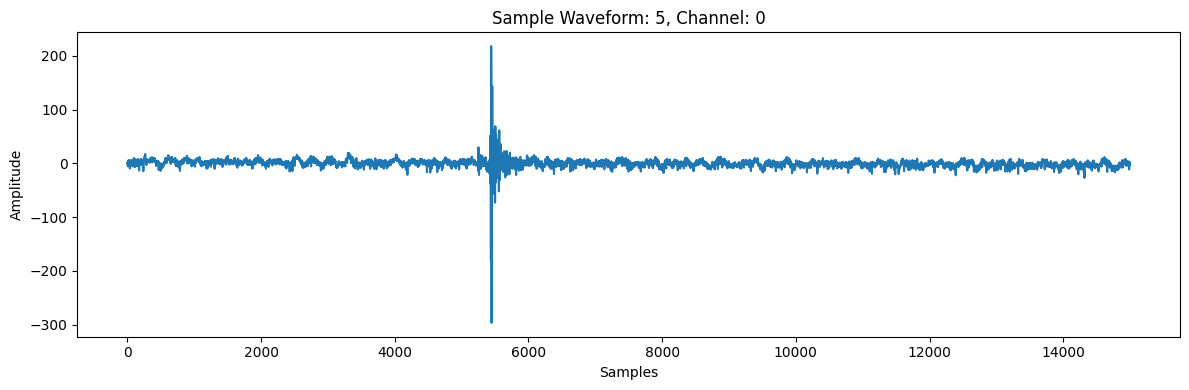

In [41]:
hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_close_to_midnight.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        sample_key = list(waveforms_group.keys())[5]
        sample_waveform = waveforms_group[sample_key][:]

        print('samplewaveform shape:', sample_waveform[0].shape)

        for i in range(len(sample_waveform[0])):
            plt.figure(figsize=(12, 4))
            y = sample_waveform[0,i,:]
            x = np.arange(len(y))
            plt.plot(x, y)
            plt.title(f"Sample Waveform: {sample_key}, Channel: {i}")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.show()
        

    

In [ ]:
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_onset,trace_P_onset
0,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,PB,EH,B013,NaN,47.813000,-122.910797,75.3,"4$0,:1,:14998","4$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,7635.0,NaN,impulsive,NaN
1,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,PB,EH,B943,NaN,47.813202,-122.911301,84.2,"10$0,:1,:14998","10$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,7650.0,NaN,impulsive,NaN
2,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,BOW,NaN,46.474831,-123.229301,870.0,"10$1,:1,:14998","10$1,:1,:14998",100,2010-01-01T00:14:27.262282Z,8079.0,NaN,impulsive,NaN
3,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,PCMD,NaN,46.888962,-122.301483,239.0,"7$0,:1,:14998","7$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,6601.0,5991.0,impulsive,impulsive
4,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,RVW,NaN,46.149750,-122.742996,504.0,"0$0,:1,:14998","0$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,NaN,7057.0,NaN,impulsive
5,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,BIB,NaN,49.410300,-123.310500,38.0,"2$0,:1,:14998","2$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,9863.0,7772.0,impulsive,impulsive
6,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,GOBB,NaN,48.949300,-123.510500,173.0,"9$0,:1,:14998","9$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,9425.0,7508.0,impulsive,impulsive
7,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,VDB,NaN,49.026100,-122.102800,404.0,"1$0,:1,:14998","1$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,NaN,6577.0,NaN,impulsive
8,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,WPB,NaN,49.647800,-123.209400,260.0,"5$0,:1,:14998","5$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,10283.0,8011.0,impulsive,impulsive
9,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,PB,EH,B001,NaN,48.043072,-123.131409,237.0,"3$0,:1,:14998","3$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,8086.0,6763.0,impulsive,impulsive


In [11]:
# Find BK station rows in assoc_df where pick_time is close to midnight (within 1 minute)
# Ensure 'datetime' column exists
if 'datetime' not in assoc_df.columns:
    assoc_df['datetime'] = pd.to_datetime(assoc_df['pick_time'], unit='s')

# Filter for BK stations
bk_mask = assoc_df['sta'].str.startswith('BK.')

# Find rows where the time is close to 23:59 (within 1 minute)
midnight_mask = assoc_df['datetime'].dt.time.between(pd.to_datetime('23:58:00').time(), pd.to_datetime('23:59:59').time())

bk_close_to_midnight = assoc_df[bk_mask & midnight_mask]
bk_close_to_midnight[['sta', 'pick_time', 'datetime']]

,sta,pick_time,datetime
324062,BK.JCC,1.338595e+09,2012-06-01 23:58:27.188393984
348863,BK.JCC,1.342656e+09,2012-07-18 23:59:42.138392832
371499,BK.JCC,1.346112e+09,2012-08-27 23:58:34.868392960
536319,BK.JCC,1.367453e+09,2013-05-01 23:59:19.488393984
536329,BK.JCC,1.367453e+09,2013-05-01 23:59:29.368393984
553360,BK.JCC,1.370045e+09,2013-05-31 23:59:13.338393088
553362,BK.JCC,1.370045e+09,2013-05-31 23:59:17.798393088
554103,BK.JCC,1.370217e+09,2013-06-02 23:58:09.088392960
733784,BK.JCC,1.404864e+09,2014-07-08 23:59:23.558393088
733795,BK.JCC,1.404864e+09,2014-07-08 23:59:28.278393088


In [12]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_BK_HH_BH_close_to_midnight.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_BK_HH_BH_close_to_midnight.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_BK_EH_close_to_midnight.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_BK_EH_close_to_midnight.csv"

# Extract network and station from sta column

df = bk_close_to_midnight.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)

# Set constants
sampling_rate = 100  # Hz
pre_arrival_time = 50  # time before the first arrival in seconds
window_length = 150  # time window length in seconds

# Create a unique event ID for each unique time
# This assumes different events have different timestamps
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

# Create 10 buckets the hdf5 file
waveform_buckets_HH_BH = {str(i): [] for i in range(11)}  # 0 to 10
waveform_buckets_EH = {str(i): [] for i in range(11)}  # 0 to 10

# Group by event_id, network and station to combine P and S arrivals
rows_HH_BH = []
rows_EH = []

group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 20):
    # Find P and S arrivals
    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")
        
    
    # Calculate trace start time (50 seconds before the first arrival)
    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time  # 50 seconds before the first arrival
    trace_end = trace_start + window_length  # 100 seconds after the first arrival

    # Convert to UTCDateTime
#     trace_start1 = obspy.UTCDateTime(trace_start).strftime('%Y-%m-%dT%H:%M:%S')
#     trace_end1 = obspy.UTCDateTime(trace_end).strftime('%Y-%m-%dT%H:%M:%S')
    ##################################################
    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)
    ##################################################
    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    # download the waveform data

    try: 
        sta = client_iris.get_stations(network=network, station=station,location="*",channel="*", \
                                    starttime=trace_start1 , endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing station info:", e)

    

    try:
        if network in ['NC', 'BK']:
            # Query waveforms
            _waveform = client_ncedc.get_waveforms(network=network, station=station, location="*", channel="*",
                                                starttime= trace_start1, endtime= trace_end1)
        else:
            # Shouldn't this have an explicit starttime + endtime inputs?
            _waveform = client_waveform.get_waveforms(network = network,
                                                    station = station,
                                                    location= "*",
                                                    channel = "?H?",
                                                    starttime = trace_start1, endtime = trace_end1)
    except Exception as e:
        print("Error during download or processing:", e)

    # Detrend
    _waveform.detrend()
    # Resample the waveform traces to 100 Hz
    _waveform.resample(100)
    # Interpolate missing data
    _waveform.merge(method=1,fill_value='interpolate')
    # Fill the gaps at the start and end of the stream
    _waveform.trim(trace_start1, trace_end1, pad=True, fill_value=0)

    
    # Store the origin data 
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0]*1000

    # Store the station metadata
    slat = sta[0][0].latitude 
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    # Create a new stream
    waveform = Stream()

    # Check if loaded data have a vertical component (minimum requirement)
    has_Z = bool(_waveform.select(channel='??Z'))

    # Check for channels presence
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    # If no vertical component is present, skip this pick
    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue
    
   # Apply selection logic based on channel presence
    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    print(f"Number of traces: {len(waveform)}")

    # # Check if the stream have 3-component data
    # if len(waveform) != 3:
    #         continue
    
    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)    


    # Print trace information
    for i, tr in enumerate(waveform):
        
        print(f"Trace {i}: id={tr.id}, tr.stats.channel={tr.stats.channel}, data shape={tr.data.shape}")

    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    # Obtain the channel code
    station_channel_code = waveform[0].stats.channel[:-1]

    # Stack the traces into a array
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)  # (3, T)
    
    # Determine the shape of the data
    num_trs = data.shape[0]
    num_tps = data.shape[1]
    
    # # save the waveform data to a seisbench format
    # h5_file = f"{network}.{station}..HHZ.{trace_start.strftime('%Y%m%dT%H%M%S')}.h5"
    # waveform.write(h5_file, format='HDF5')

    
    # Calculate P and S samples
    p_sample = None
    if not p_arrival.empty:
        p_time = p_arrival['pick_time'].iloc[0]
        p_sample = int((p_time - trace_start) * sampling_rate)
    
    s_sample = None
    if not s_arrival.empty:
        s_time = s_arrival['pick_time'].iloc[0]
        s_sample = int((s_time - trace_start) * sampling_rate)
    
    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")

/tmp/ipykernel_1085424/1895035309.py:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


No S arrival for event ev1338595094_500369 at station JCC
Trace start: 2012-06-01T23:57:24.500369Z, Trace end: 2012-06-01T23:59:54.500369Z
Number of traces: 3
Trace 0: id=BK.JCC.00.HHE, tr.stats.channel=HHE, data shape=(15001,)
Trace 1: id=BK.JCC.00.HHN, tr.stats.channel=HHN, data shape=(15001,)
Trace 2: id=BK.JCC.00.HHZ, tr.stats.channel=HHZ, data shape=(15001,)
No S arrival for event ev1342655970_505147 at station JCC
Trace start: 2012-07-18T23:58:40.505147Z, Trace end: 2012-07-19T00:01:10.505147Z
Number of traces: 3
Trace 0: id=BK.JCC.00.HHE, tr.stats.channel=HHE, data shape=(15001,)
Trace 1: id=BK.JCC.00.HHN, tr.stats.channel=HHN, data shape=(15001,)
Trace 2: id=BK.JCC.00.HHZ, tr.stats.channel=HHZ, data shape=(15001,)
No S arrival for event ev1346111897_526979 at station JCC
Trace start: 2012-08-27T23:57:27.526979Z, Trace end: 2012-08-27T23:59:57.526979Z
Number of traces: 3
Trace 0: id=BK.JCC.00.HHE, tr.stats.channel=HHE, data shape=(15001,)
Trace 1: id=BK.JCC.00.HHN, tr.stats.chan

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['0', '1', '10', '3', '4', '5', '7', '8', '9']>
 - 0: shape=(1, 3, 14998), min=-11011.39, max=10879.70
 - 1: shape=(1, 3, 14998), min=-4726.96, max=4183.62
 - 10: shape=(1, 3, 14998), min=-13046.28, max=12429.43
 - 3: shape=(1, 3, 14998), min=-6039.16, max=5087.05
 - 4: shape=(1, 3, 14998), min=-3750.35, max=3536.15
 - 5: shape=(3, 3, 14998), min=-7697.05, max=8375.01
 - 7: shape=(1, 3, 14998), min=-7262.71, max=4824.10
 - 8: shape=(1, 3, 14998), min=-2361.81, max=3281.59
 - 9: shape=(1, 3, 14998), min=-7274.69, max=8677.53
samplewaveform shape: (3, 14998)


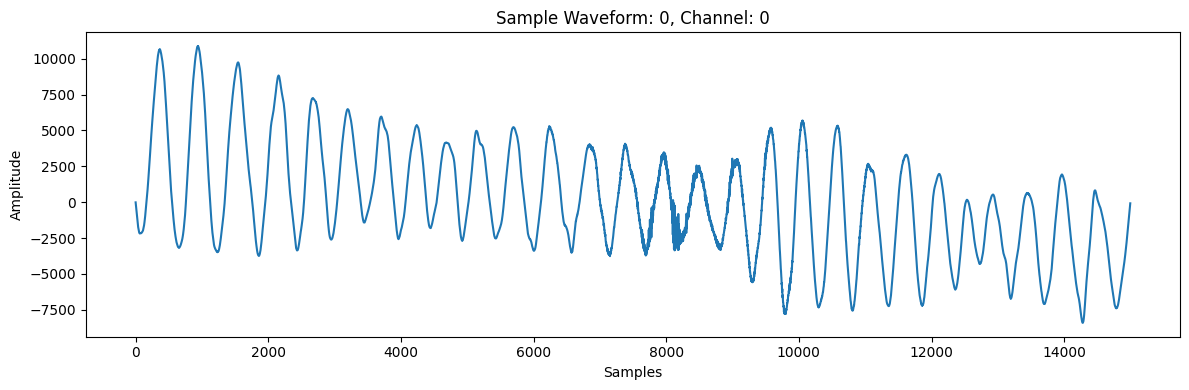

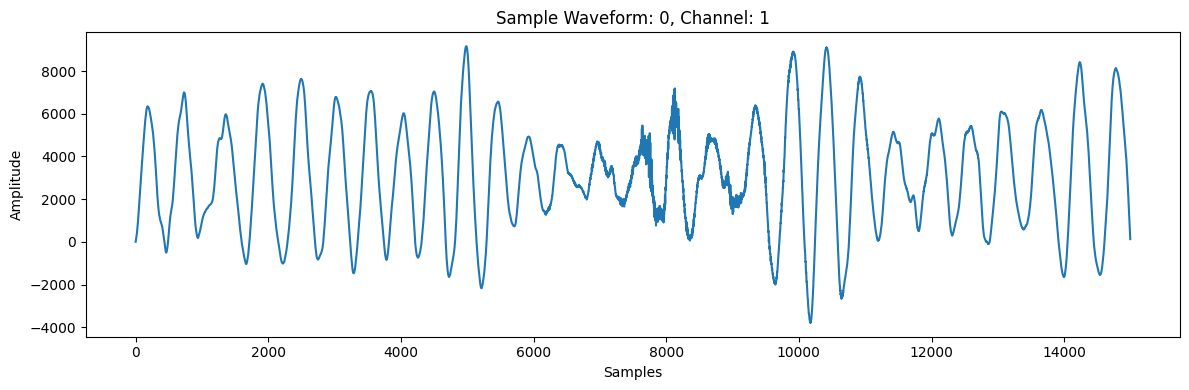

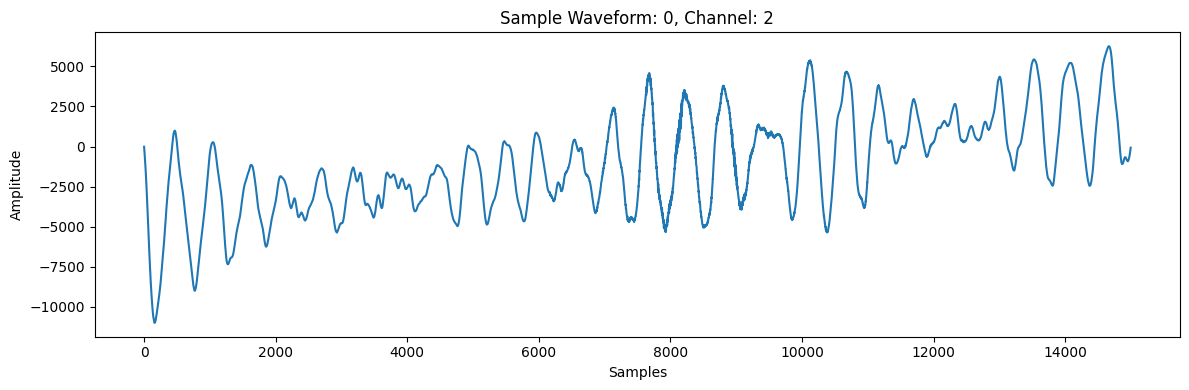

In [13]:
hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_BK_HH_BH_close_to_midnight.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        sample_key = list(waveforms_group.keys())[0]
        sample_waveform = waveforms_group[sample_key][:]

        print('samplewaveform shape:', sample_waveform[0].shape)

        for i in range(len(sample_waveform[0])):
            plt.figure(figsize=(12, 4))
            y = sample_waveform[0,i,:]
            x = np.arange(len(y))
            plt.plot(x, y)
            plt.title(f"Sample Waveform: {sample_key}, Channel: {i}")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.show()
        

    

In [ ]:
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_onset,trace_P_onset
0,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,PB,EH,B013,NaN,47.813000,-122.910797,75.3,"4$0,:1,:14998","4$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,7635.0,NaN,impulsive,NaN
1,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,PB,EH,B943,NaN,47.813202,-122.911301,84.2,"10$0,:1,:14998","10$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,7650.0,NaN,impulsive,NaN
2,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,BOW,NaN,46.474831,-123.229301,870.0,"10$1,:1,:14998","10$1,:1,:14998",100,2010-01-01T00:14:27.262282Z,8079.0,NaN,impulsive,NaN
3,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,PCMD,NaN,46.888962,-122.301483,239.0,"7$0,:1,:14998","7$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,6601.0,5991.0,impulsive,impulsive
4,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,RVW,NaN,46.149750,-122.742996,504.0,"0$0,:1,:14998","0$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,NaN,7057.0,NaN,impulsive
5,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,BIB,NaN,49.410300,-123.310500,38.0,"2$0,:1,:14998","2$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,9863.0,7772.0,impulsive,impulsive
6,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,GOBB,NaN,48.949300,-123.510500,173.0,"9$0,:1,:14998","9$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,9425.0,7508.0,impulsive,impulsive
7,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,VDB,NaN,49.026100,-122.102800,404.0,"1$0,:1,:14998","1$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,NaN,6577.0,NaN,impulsive
8,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,WPB,NaN,49.647800,-123.209400,260.0,"5$0,:1,:14998","5$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,10283.0,8011.0,impulsive,impulsive
9,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,PB,EH,B001,NaN,48.043072,-123.131409,237.0,"3$0,:1,:14998","3$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,8086.0,6763.0,impulsive,impulsive


In [23]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_EH.csv"

# Extract network and station from sta column

df = assoc_df.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)

# Set constants
sampling_rate = 100  # Hz
pre_arrival_time = 50  # time before the first arrival in seconds
window_length = 150  # time window length in seconds

# Create a unique event ID for each unique time
# This assumes different events have different timestamps
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

# Create 10 buckets the hdf5 file
waveform_buckets_HH_BH = {str(i): [] for i in range(11)}  # 0 to 10
waveform_buckets_EH = {str(i): [] for i in range(11)}  # 0 to 10

# Group by event_id, network and station to combine P and S arrivals
rows_HH_BH = []
rows_EH = []

group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 20):
    # Find P and S arrivals
    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")
        
    
    # Calculate trace start time (50 seconds before the first arrival)
    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time  # 50 seconds before the first arrival
    trace_end = trace_start + window_length  # 100 seconds after the first arrival

    # Convert to UTCDateTime
#     trace_start1 = obspy.UTCDateTime(trace_start).strftime('%Y-%m-%dT%H:%M:%S')
#     trace_end1 = obspy.UTCDateTime(trace_end).strftime('%Y-%m-%dT%H:%M:%S')
    ##################################################
    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)
    ##################################################
    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    # download the waveform data

    try: 
        sta = client_iris.get_stations(network=network, station=station,location="*",channel="*", \
                                    starttime=trace_start1 , endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing station info:", e)

    except Exception as e:
        print("Error during download or processing waveforms:", e)

    try:
        if network in ['NC', 'BK']:
            # Query waveforms
            _waveform = client_ncedc.get_waveforms(network=network, station=station, location="*", channel="*",
                                                starttime= trace_start1, endtime= trace_end1)
        else:
            # Shouldn't this have an explicit starttime + endtime inputs?
            _waveform = client_waveform.get_waveforms(network = network,
                                                    station = station,
                                                    location= "*",
                                                    channel = "?H?",
                                                    starttime = trace_start1, endtime = trace_end1)
    except Exception as e:
        print("Error during download or processing:", e)

    # Detrend
    _waveform.detrend()
    # Resample the waveform traces to 100 Hz
    _waveform.resample(100)
    # Interpolate missing data
    _waveform.merge(method=1,fill_value='interpolate')
    # Fill the gaps at the start and end of the stream
    _waveform.trim(trace_start1, trace_end1, pad=True, fill_value=0)

    
    # Store the origin data 
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0]*1000

    # Store the station metadata
    slat = sta[0][0].latitude 
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    # Create a new stream
    waveform = Stream()

    # Check if loaded data have a vertical component (minimum requirement)
    has_Z = bool(_waveform.select(channel='??Z'))

    # Check for channels presence
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    # If no vertical component is present, skip this pick
    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue
    
   # Apply selection logic based on channel presence
    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    print(f"Number of traces: {len(waveform)}")

    # # Check if the stream have 3-component data
    # if len(waveform) != 3:
    #         continue
    
    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)    


    # Print trace information
    for i, tr in enumerate(waveform):
        
        print(f"Trace {i}: id={tr.id}, tr.stats.channel={tr.stats.channel}, data shape={tr.data.shape}")

    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    # Obtain the channel code
    station_channel_code = waveform[0].stats.channel[:-1]

    # Stack the traces into a array
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)  # (3, T)
    
    # Determine the shape of the data
    num_trs = data.shape[0]
    num_tps = data.shape[1]
    
    # # save the waveform data to a seisbench format
    # h5_file = f"{network}.{station}..HHZ.{trace_start.strftime('%Y%m%dT%H%M%S')}.h5"
    # waveform.write(h5_file, format='HDF5')

    
    # Calculate P and S samples
    p_sample = None
    if not p_arrival.empty:
        p_time = p_arrival['pick_time'].iloc[0]
        p_sample = int((p_time - trace_start) * sampling_rate)
    
    s_sample = None
    if not s_arrival.empty:
        s_time = s_arrival['pick_time'].iloc[0]
        s_sample = int((s_time - trace_start) * sampling_rate)
    
    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")



/tmp/ipykernel_1079918/3486799781.py:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


KeyboardInterrupt: 